# Task 1: Sea, Mountain, or Jungle

In this task, we should determine whether the image depicts a sea, mountain, or jungle. We have a multi-class classification problem in here:

In [ ]:
!git clone https://github.com/davda54/sam.git

Cloning into 'sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 200 (delta 85), reused 67 (delta 67), pack-reused 97
Receiving objects: 100% (200/200), 657.08 KiB | 9.66 MiB/s, done.
Resolving deltas: 100% (100/100), done.


**Import Libraries**

In [ ]:
import os
import torch
import random
from PIL import Image
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from torchvision import transforms
from torchvision.models import resnet152, mobilenet_v3_small
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from sam.sam import SAM
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Set Random Seeds and Parameters**

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Data and Saving Path**

In [ ]:
img_path = '/content/drive/MyDrive/ML-Data/ML Project Dataset - train'
label_path = '/content/drive/MyDrive/ML-Data/'
model_save_path = '/content/drive/MyDrive/ML-Data/weights'

We divided our data in 2 parts: Train and Validation. Train data will be 80% of all data and Validation is the remained part, 20% of data:

In [ ]:
train_df = pd.read_csv(label_path + 'train_dataset.csv')
val_df = pd.read_csv(label_path + 'val_dataset.csv')

In [ ]:
train_df.head()

Unnamed: 0.1  Unnamed: 0                           Image_name  \
0           521         521  810100406-real-none-mountain-10.jpg   
1           522         522   810100406-real-none-mountain-2.jpg   
2          2161        2161   810199424_fake_stable_jungle_2.jpg   
3           727         727  810100503_fake_dalle_mountain_3.jpg   
4          3053        3053        830400052_real_none_sea_5.jpg   

   Nature_label  Fake_label Nature_cat Fake_cat  
0             1           1   mountain     real  
1             1           1   mountain     real  
2             0           0     jungle     fake  
3             1           0   mountain     fake  
4             2           1        sea     real

Our dataset is approximately balanced in both train and test sets:

In [ ]:
train_df['Nature_cat'].value_counts()

jungle      842
mountain    837
sea         815
Name: Nature_cat, dtype: int64

In [ ]:
val_df['Nature_cat'].value_counts()

sea         225
mountain    203
jungle      196
Name: Nature_cat, dtype: int64

**Custome Dataset**


*   `root_dir`: The path to image directory
*   `annotation_file`: Tha path to .csv file containing labels
*   `label_column`: Determines classification task
* `transform`: The transformation we want to apply on images



In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label_df, label_column, transform=None):
        self.root_dir = root_dir
        self.label_df = label_df
        self.transform = transform
        self.data = self.read_annotations(label_column)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def read_annotations(self, label_column):
        image_list = list(self.label_df['Image_name'])
        label_list = list(self.label_df[label_column])

        data = [(img, label) for img, label in zip(image_list, label_list)]

        return data

**From Scratch CNN Model**

Here is the class implementation of CNN model mentioned in project documentation. To create a CNNModel, we should determine `output_dim` in initialization:

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, output_dim):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)  # Output: (112, 112, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (56, 56, 64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Output: (56, 56, 64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=4, padding=1)  # Output: (14, 14, 256)
        self.bn6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output: (14, 14, 256)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU()

        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # Output: (7, 7, 512)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU()

        # Average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Output: (1, 1, 512)
        self.fc = nn.Linear(512, output_dim)  # Output: (output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.bn6(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x


Here we can see details about our CNNModel, different layers, output shape of each layer and trainable/ Non-trainable parameters (Note: all of our images have input shape `(3, 224, 224)`):

In [ ]:
cnn = CNNModel(3)
summary(cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           4,864
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]         147,584
      BatchNorm2d-11          [-1, 128, 56, 56]             256
           Conv2d-12          [-1, 128, 56, 56]         147,584
      BatchNorm2d-13          [-1, 128, 56, 56]             256
             ReLU-14          [-1, 128,

Now it's time for pretrained models!

The first pretrained model we have is **ResNet-152**. ResNet Networks introduce skip connection (or shortcut connection) to fit the input from the previous layer to the next layer without any modification of the input.

In this scenario, we freeze all weights of ResNet except the classification layer. In other words, we use ResNet as a feature extractor in here:

According to ResNet-152 architecture, we just change the last fully connected layer:

In [ ]:
resnet152(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

 **Customizing ResNet152 for Classification**

In [ ]:
class CustomResNet152Frozen(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet152Frozen, self).__init__()
        # Load the pre-trained ResNet-152 model with frozen weights
        resnet = resnet152(pretrained=True)

        # Freeze all layers except the classification layer
        for param in resnet.parameters():
            param.requires_grad = False

        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)

        self.model = resnet

    def forward(self, x):
        x = self.model(x)
        return x

The second pretrained model we have is **MobileNet-V3**. MobileNetV3 is a convolutional neural network that is tuned to mobile phone CPUs through a combination of hardware-aware network architecture search (NAS) complemented by the NetAdapt algorithm, and then subsequently improved through novel architecture advances.



Here we use the small version of MobileNet. Because our dataset is small, it seems that we don't need a huge model. To customize model for our task, we just change the last layer in the classifier of MobileNet:

In [ ]:
mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

**Customizing MobileNetV3 for Classification**

In [ ]:
class CustomMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV3, self).__init__()
        # Load the pre-trained MobileNet-V3 model with frozen weights
        mobile = mobilenet_v3_small(pretrained=True)

        # Freeze all layers except the classification layer
        for param in mobile.parameters():
            param.requires_grad = False

        num_ftrs = mobile.classifier[-1].in_features
        mobile.classifier[-1] = nn.Linear(num_ftrs, num_classes)

        self.model = mobile


    def forward(self, x):
        x = self.model(x)
        return x

**function to plot learning curve**

We utilize the following function to plot model loss and accuracy in the training process on both train and validation datasets:

In [ ]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, plot_title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Learning Curves with {plot_title}')
    plt.show()


# Impact of Data Augmentation

In this section, we will see the impact of different data augmentation methods on model performance.



**MixUp data augmentation method**

At first, we implement MixUp method!

This transform is a little different from other data augmentation methods: it expects batches of samples as input, not individual images. Mixup is a domain-agnostic data augmentation technique. It's implemented with the following formulas:
![](https://i.ibb.co/DRyHYww/image.png)

The lambda values are values with the [0, 1] range and are sampled from the Beta distribution.

In [ ]:
def mixup_label(label, lam, num_classes):
        label = one_hot(label, num_classes=num_classes)
        if not label.dtype.is_floating_point:
            label = label.float()
        return label.roll(1, 0).mul_(1.0 - lam).add_(label.mul(lam))

In [ ]:
def mixup_data(inputs, labels, num_classes, alpha=1.0):
    """Applies mixup augmentation to a batch of inputs and integer labels.

    Args:
        inputs: A batch of input tensors (e.g., images or features).
        labels: A batch of integer labels.
        alpha: Hyperparameter for the Beta distribution used to sample mixing ratios.

    Returns:
        A tuple containing the mixed inputs and mixed labels.
    """

    lam = torch.distributions.Beta(torch.tensor([alpha]), torch.tensor([alpha])).sample()
    lam = lam.to(device)
    batch_size = labels.shape[0]

    # Mixup inputs
    mixed_inputs = lam * inputs + (1 - lam) * inputs.roll(1, 0)

    # Mixup labels (integer mixing)
    mixed_labels = mixup_label(labels, lam, num_classes)
    return mixed_inputs, mixed_labels

To see the effect of different transforms and model training, we use the following function. The model will be saved after training and we will train and validation accuracies to plot model curves:

In [ ]:
def train_model_with_transforms(model, train_loader, val_loader, criterion, optimizer, scheduler, transform, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train = []
        all_predictions_train = []

        for inputs, labels  in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            if transform == 'mixup':
                mixup_inputs, mixup_labels = mixup_data(inputs, labels, num_classes=3)
                outputs = model(mixup_inputs)
                loss = criterion(outputs, mixup_labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_predictions_train.extend(predicted_train.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy_train = correct_train / total_train
        train_accuracies.append(epoch_accuracy_train)

        # Calculate F1 score
        f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        all_labels_val = []
        all_predictions_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs_val = model(inputs)
                loss_val = criterion(outputs_val, labels)
                running_loss_val += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_predictions_val.extend(predicted_val.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        val_losses.append(epoch_loss_val)
        epoch_accuracy_val = correct_val / total_val
        val_accuracies.append(epoch_accuracy_val)

        # Calculate F1 score
        f1_val = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # Update learning rate
        scheduler.step()

        # Print and store results for analysis
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy_train*100:.2f}% | Train F1: {f1_train*100:.2f}%')
        print(f'\t Val. Loss: {epoch_loss_val:.3f} |  Val. Acc: {epoch_accuracy_val*100:.2f}% | Val F1: {f1_val*100:.2f}%')


    # Save the model weights after training
    torch.save(model.state_dict(), f'{model_save_path}/{model._get_name()}_{transform}.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

At first, we start our experiments with ResNet!

## ResNet-152

In the following, we have the list of all of the transforms:

In [ ]:
# Define different augmentation methods
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
random_rotation = transforms.RandomRotation(degrees=45)
random_crop = transforms.RandomCrop(size=(200, 200))
gaussian_blur = transforms.GaussianBlur(kernel_size=3)
grayscale = transforms.Grayscale(num_output_channels=3)
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
vertical_flip = transforms.RandomVerticalFlip(p=0.5)

### Without any Augmentation

Firstly, we start our work without any augmentation. We just use `ToTensor()` transform to make images ready for model training:

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

We will use a fixed optimizer and LR scheduler for all of the models in this part: Adam and StepLR

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

At first, let's talk about overfitting. It seems that after 7 or 8 epochs, we can witness overfitting in the model training: because we can see an accuracy drop in the plot and also the decrease of loss has stopped after that point.

Another interesting point that we can see in these plot is the fact the validation loss is less than training loss and also validation accuracy is higher than train accuracy.

Many reasons could be behind this behavior but I found this more sensible:
+ *smaller datasets have smaller intrinsic variance so this means that your model properly captures patterns inside of your data and train error is greater simply because the inner variance of training set is greater then validation set.*


Epoch: 01
	Train Loss: 0.437 | Train Acc: 84.92% | Train F1: 84.93%
	 Val. Loss: 0.208 |  Val. Acc: 93.43% | Val F1: 93.46%
Epoch: 02
	Train Loss: 0.219 | Train Acc: 92.50% | Train F1: 92.50%
	 Val. Loss: 0.137 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 03
	Train Loss: 0.173 | Train Acc: 94.23% | Train F1: 94.23%
	 Val. Loss: 0.136 |  Val. Acc: 95.83% | Val F1: 95.83%
Epoch: 04
	Train Loss: 0.162 | Train Acc: 94.99% | Train F1: 94.99%
	 Val. Loss: 0.112 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 05
	Train Loss: 0.143 | Train Acc: 95.31% | Train F1: 95.31%
	 Val. Loss: 0.109 |  Val. Acc: 96.47% | Val F1: 96.48%
Epoch: 06
	Train Loss: 0.126 | Train Acc: 95.91% | Train F1: 95.91%
	 Val. Loss: 0.102 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 07
	Train Loss: 0.128 | Train Acc: 96.27% | Train F1: 96.27%
	 Val. Loss: 0.103 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 08
	Train Loss: 0.116 | Train Acc: 96.99% | Train F1: 96.99%
	 Val. Loss: 0.100 |  Val. Acc: 97.12% | Val F1: 97.11%
Epoch: 0

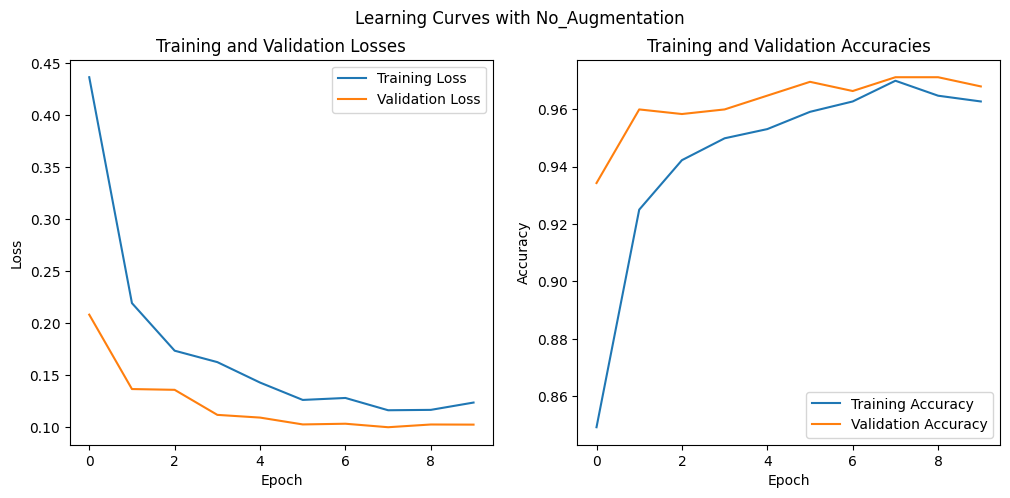

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "No_Augmentation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "No_Augmentation")

### ColorJitter

The ColorJitter transform randomly changes the brightness, contrast, saturation, hue, and other properties of an image. The amount of jittering for brightness, saturation and contrast will be chosen uniformly from [max(0, 1 - value), 1 + value].  For hue you can provide just one float number between 0 or 0.5.
![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_012.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

With using ColorJitter, it seems that our model overfits earlier (epoch 5-6). We see some ups and downs in validation accuracy, They seems to be the results of overfitting

Epoch: 01
	Train Loss: 0.500 | Train Acc: 81.03% | Train F1: 81.07%
	 Val. Loss: 0.212 |  Val. Acc: 92.47% | Val F1: 92.54%
Epoch: 02
	Train Loss: 0.248 | Train Acc: 91.70% | Train F1: 91.70%
	 Val. Loss: 0.145 |  Val. Acc: 96.47% | Val F1: 96.48%
Epoch: 03
	Train Loss: 0.232 | Train Acc: 92.30% | Train F1: 92.31%
	 Val. Loss: 0.130 |  Val. Acc: 96.15% | Val F1: 96.15%
Epoch: 04
	Train Loss: 0.198 | Train Acc: 93.83% | Train F1: 93.83%
	 Val. Loss: 0.122 |  Val. Acc: 97.12% | Val F1: 97.11%
Epoch: 05
	Train Loss: 0.193 | Train Acc: 93.58% | Train F1: 93.58%
	 Val. Loss: 0.144 |  Val. Acc: 94.55% | Val F1: 94.59%
Epoch: 06
	Train Loss: 0.173 | Train Acc: 94.11% | Train F1: 94.11%
	 Val. Loss: 0.106 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 07
	Train Loss: 0.156 | Train Acc: 95.15% | Train F1: 95.15%
	 Val. Loss: 0.109 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 08
	Train Loss: 0.167 | Train Acc: 94.51% | Train F1: 94.51%
	 Val. Loss: 0.109 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 0

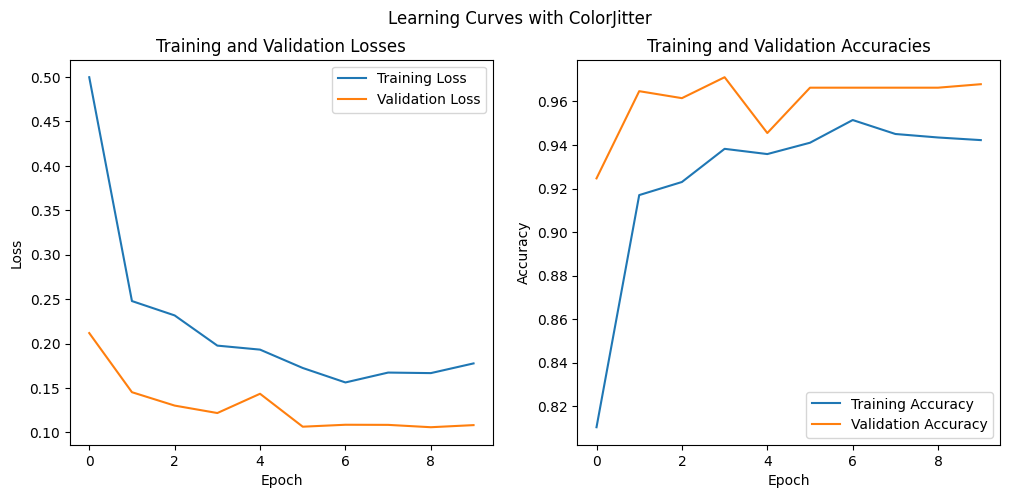

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "ColorJitter",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ColorJitter")

### RandomRotation

The RandomRotation transform rotates an image with random angle. If you provide just a number for degree, the range of rotation will be (-degree, +degree).
![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_006.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_rotation,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

According the last two parts, here we can observe a drop in performance (based on accuracy)

Epoch: 01
	Train Loss: 0.527 | Train Acc: 82.00% | Train F1: 82.03%
	 Val. Loss: 0.238 |  Val. Acc: 93.27% | Val F1: 93.26%
Epoch: 02
	Train Loss: 0.312 | Train Acc: 89.05% | Train F1: 89.06%
	 Val. Loss: 0.210 |  Val. Acc: 92.15% | Val F1: 92.14%
Epoch: 03
	Train Loss: 0.293 | Train Acc: 89.82% | Train F1: 89.83%
	 Val. Loss: 0.182 |  Val. Acc: 93.91% | Val F1: 93.88%
Epoch: 04
	Train Loss: 0.251 | Train Acc: 91.30% | Train F1: 91.30%
	 Val. Loss: 0.147 |  Val. Acc: 94.71% | Val F1: 94.73%
Epoch: 05
	Train Loss: 0.242 | Train Acc: 91.38% | Train F1: 91.39%
	 Val. Loss: 0.152 |  Val. Acc: 93.91% | Val F1: 93.91%
Epoch: 06
	Train Loss: 0.221 | Train Acc: 92.30% | Train F1: 92.32%
	 Val. Loss: 0.148 |  Val. Acc: 94.87% | Val F1: 94.85%
Epoch: 07
	Train Loss: 0.202 | Train Acc: 93.02% | Train F1: 93.03%
	 Val. Loss: 0.137 |  Val. Acc: 95.19% | Val F1: 95.18%
Epoch: 08
	Train Loss: 0.227 | Train Acc: 92.10% | Train F1: 92.10%
	 Val. Loss: 0.135 |  Val. Acc: 95.51% | Val F1: 95.49%
Epoch: 0

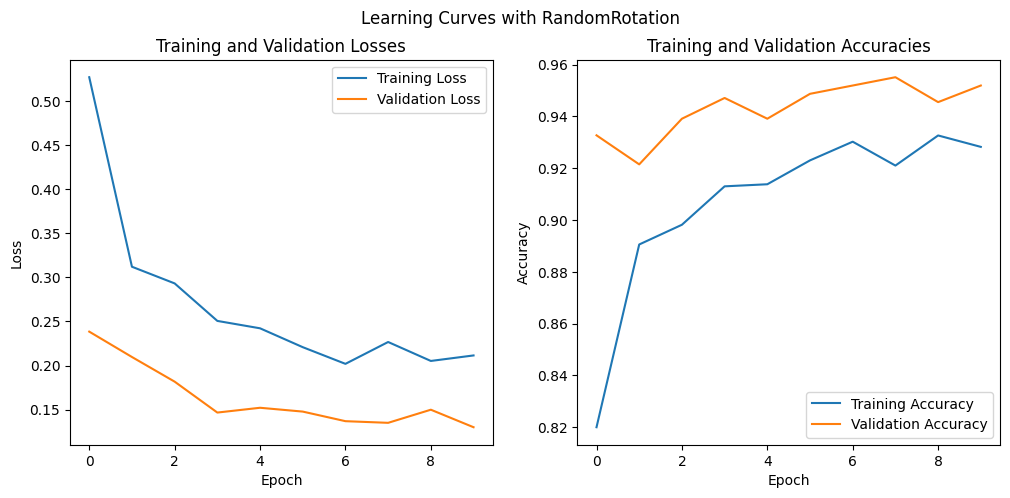

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomRotation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomRotation")

### RandomCrop

The RandomCrop transform crops an image at a random location. The size will determine our desired size for cropping.
![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_009.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_crop,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

RandomCrop has also promising results. After 5 or 6 epochs, we can see overfitting:

Epoch: 01
	Train Loss: 0.433 | Train Acc: 85.32% | Train F1: 85.34%
	 Val. Loss: 0.189 |  Val. Acc: 94.07% | Val F1: 94.09%
Epoch: 02
	Train Loss: 0.217 | Train Acc: 93.30% | Train F1: 93.31%
	 Val. Loss: 0.133 |  Val. Acc: 96.31% | Val F1: 96.31%
Epoch: 03
	Train Loss: 0.174 | Train Acc: 94.39% | Train F1: 94.39%
	 Val. Loss: 0.121 |  Val. Acc: 95.99% | Val F1: 95.99%
Epoch: 04
	Train Loss: 0.155 | Train Acc: 95.27% | Train F1: 95.27%
	 Val. Loss: 0.120 |  Val. Acc: 96.63% | Val F1: 96.62%
Epoch: 05
	Train Loss: 0.142 | Train Acc: 94.91% | Train F1: 94.91%
	 Val. Loss: 0.114 |  Val. Acc: 96.15% | Val F1: 96.14%
Epoch: 06
	Train Loss: 0.128 | Train Acc: 95.83% | Train F1: 95.83%
	 Val. Loss: 0.107 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 07
	Train Loss: 0.124 | Train Acc: 96.31% | Train F1: 96.31%
	 Val. Loss: 0.108 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 08
	Train Loss: 0.132 | Train Acc: 95.51% | Train F1: 95.51%
	 Val. Loss: 0.104 |  Val. Acc: 97.12% | Val F1: 97.11%
Epoch: 0

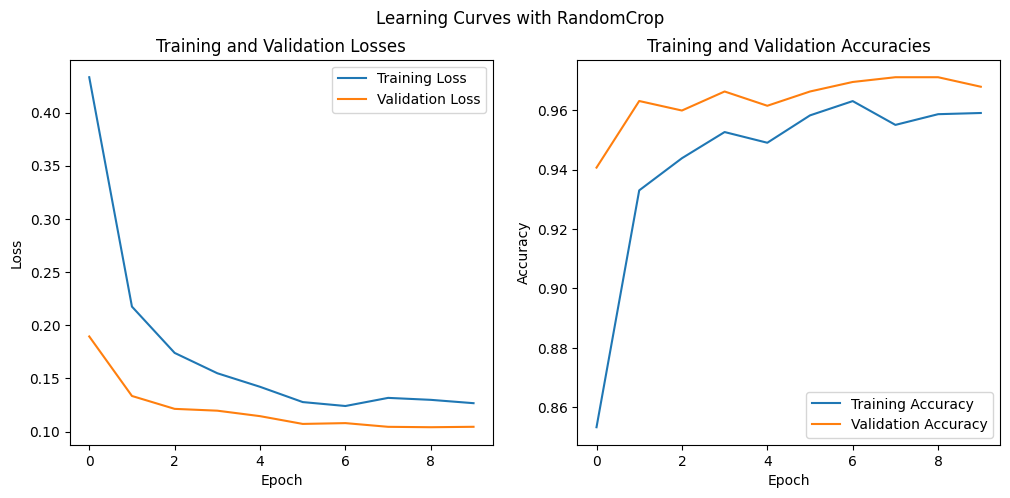

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomCrop",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomCrop")

### GaussianBlur

The GaussianBlur transform performs gaussian blur transform on an image. We should provide the kernel size we want to use for this transform.
![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_013.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        gaussian_blur,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In comparison with other transforms, this transform has good results too:

Epoch: 01
	Train Loss: 0.449 | Train Acc: 84.28% | Train F1: 84.28%
	 Val. Loss: 0.175 |  Val. Acc: 95.19% | Val F1: 95.20%
Epoch: 02
	Train Loss: 0.219 | Train Acc: 92.90% | Train F1: 92.91%
	 Val. Loss: 0.136 |  Val. Acc: 95.83% | Val F1: 95.83%
Epoch: 03
	Train Loss: 0.178 | Train Acc: 93.95% | Train F1: 93.95%
	 Val. Loss: 0.138 |  Val. Acc: 95.51% | Val F1: 95.50%
Epoch: 04
	Train Loss: 0.167 | Train Acc: 94.71% | Train F1: 94.71%
	 Val. Loss: 0.108 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 05
	Train Loss: 0.170 | Train Acc: 94.51% | Train F1: 94.51%
	 Val. Loss: 0.104 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 06
	Train Loss: 0.132 | Train Acc: 95.75% | Train F1: 95.75%
	 Val. Loss: 0.102 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 07
	Train Loss: 0.125 | Train Acc: 96.31% | Train F1: 96.31%
	 Val. Loss: 0.103 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 08
	Train Loss: 0.130 | Train Acc: 96.03% | Train F1: 96.03%
	 Val. Loss: 0.105 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 0

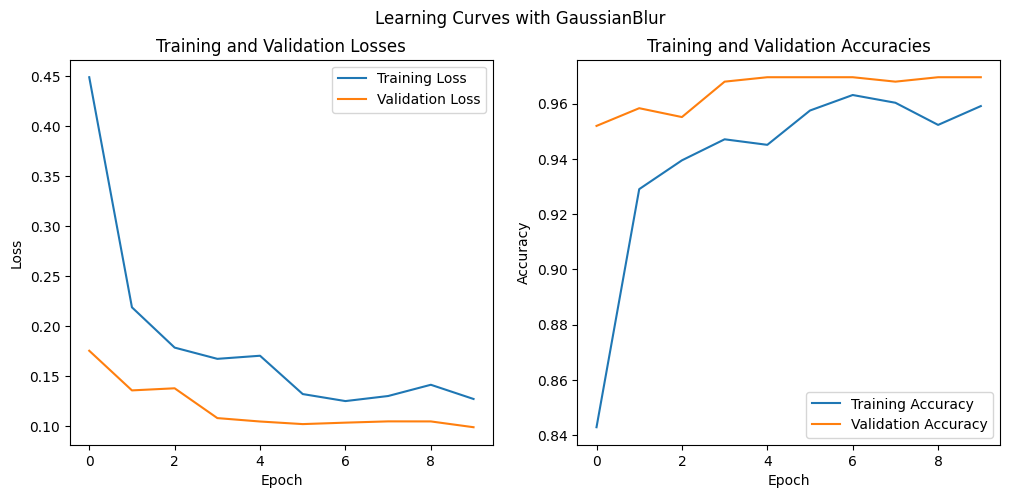

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "GaussianBlur",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "GaussianBlur")

### Grayscale

The Grayscale transform converts an image to grayscale. If we want to had 3 channel output image at the end, we should specify it in num_output_channels.

![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_011.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        grayscale,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We expected that this transform will deteriorate our model performance, because removing color features from an image will remove many useful features from it.

We have a acceptable accuracy on training set but poor results on test set:

Epoch: 01
	Train Loss: 0.533 | Train Acc: 78.95% | Train F1: 78.97%
	 Val. Loss: 1.155 |  Val. Acc: 49.36% | Val F1: 40.47%
Epoch: 02
	Train Loss: 0.289 | Train Acc: 90.18% | Train F1: 90.17%
	 Val. Loss: 1.426 |  Val. Acc: 40.22% | Val F1: 27.56%
Epoch: 03
	Train Loss: 0.237 | Train Acc: 92.30% | Train F1: 92.30%
	 Val. Loss: 1.502 |  Val. Acc: 42.79% | Val F1: 32.52%
Epoch: 04
	Train Loss: 0.223 | Train Acc: 91.86% | Train F1: 91.86%
	 Val. Loss: 1.744 |  Val. Acc: 38.62% | Val F1: 27.03%
Epoch: 05
	Train Loss: 0.190 | Train Acc: 93.74% | Train F1: 93.74%
	 Val. Loss: 1.523 |  Val. Acc: 40.06% | Val F1: 33.67%
Epoch: 06
	Train Loss: 0.172 | Train Acc: 93.99% | Train F1: 93.99%
	 Val. Loss: 1.512 |  Val. Acc: 41.83% | Val F1: 35.70%
Epoch: 07
	Train Loss: 0.172 | Train Acc: 94.07% | Train F1: 94.06%
	 Val. Loss: 1.701 |  Val. Acc: 39.26% | Val F1: 32.24%
Epoch: 08
	Train Loss: 0.177 | Train Acc: 93.74% | Train F1: 93.75%
	 Val. Loss: 1.456 |  Val. Acc: 42.31% | Val F1: 37.66%
Epoch: 0

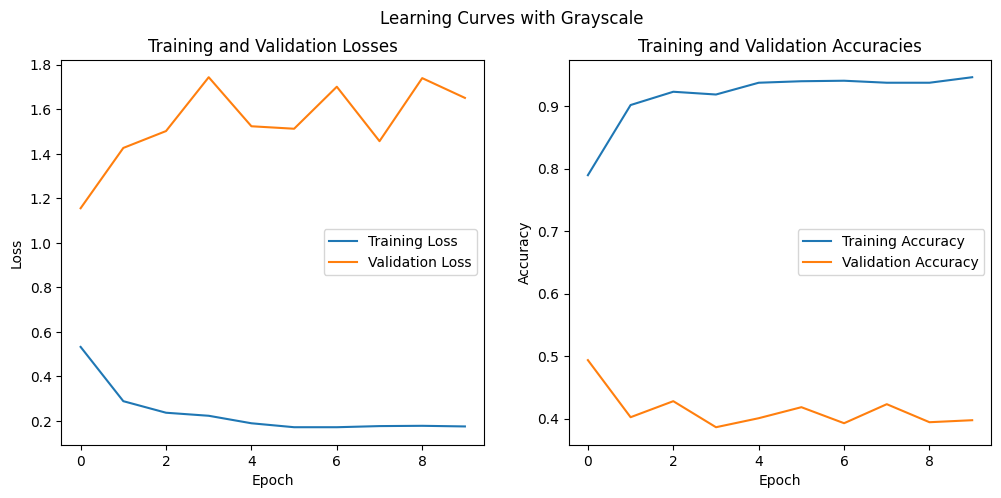

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "Grayscale",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Grayscale")

### RandomHorizontalFlip

These transforms (Random ho/ver Flips) perform horizontal/vertical flip of an image, with a given probability.
![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_024.png)
![](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_illustrations_025.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        horizontal_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

The results are like the previous parts but the intersting thing is here is that at some point train accuracy is higher than val accuracy

Epoch: 01
	Train Loss: 0.434 | Train Acc: 86.25% | Train F1: 86.25%
	 Val. Loss: 0.217 |  Val. Acc: 92.79% | Val F1: 92.87%
Epoch: 02
	Train Loss: 0.212 | Train Acc: 93.62% | Train F1: 93.63%
	 Val. Loss: 0.164 |  Val. Acc: 94.39% | Val F1: 94.46%
Epoch: 03
	Train Loss: 0.176 | Train Acc: 94.23% | Train F1: 94.23%
	 Val. Loss: 0.140 |  Val. Acc: 96.63% | Val F1: 96.61%
Epoch: 04
	Train Loss: 0.162 | Train Acc: 94.95% | Train F1: 94.95%
	 Val. Loss: 0.117 |  Val. Acc: 95.67% | Val F1: 95.70%
Epoch: 05
	Train Loss: 0.156 | Train Acc: 94.55% | Train F1: 94.55%
	 Val. Loss: 0.111 |  Val. Acc: 95.99% | Val F1: 96.01%
Epoch: 06
	Train Loss: 0.123 | Train Acc: 96.23% | Train F1: 96.23%
	 Val. Loss: 0.106 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 07
	Train Loss: 0.115 | Train Acc: 96.55% | Train F1: 96.55%
	 Val. Loss: 0.105 |  Val. Acc: 96.47% | Val F1: 96.47%
Epoch: 08
	Train Loss: 0.119 | Train Acc: 96.35% | Train F1: 96.35%
	 Val. Loss: 0.104 |  Val. Acc: 96.47% | Val F1: 96.48%
Epoch: 0

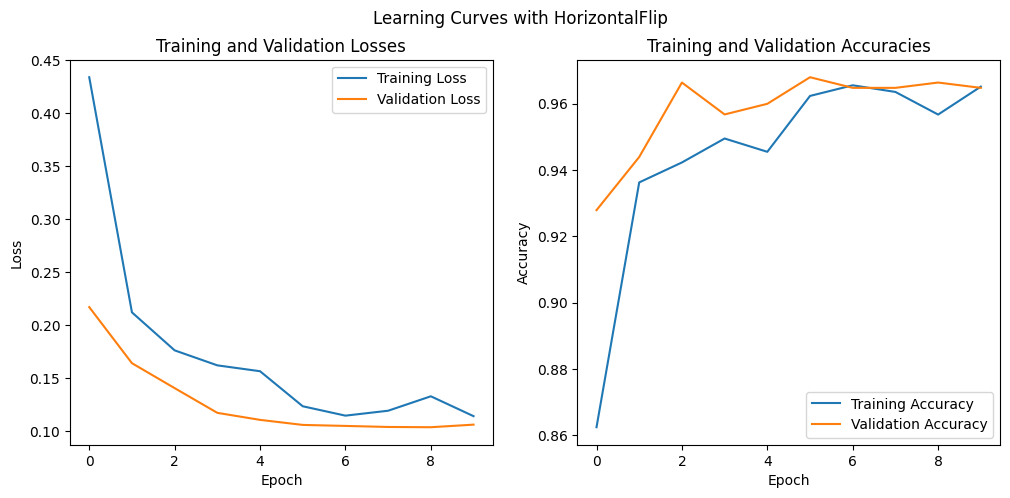

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "HorizontalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "HorizontalFlip")

### RandomVerticalFlip

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        vertical_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Like others but it took more time to converge in this scenario:

Epoch: 01
	Train Loss: 0.439 | Train Acc: 85.40% | Train F1: 85.40%
	 Val. Loss: 0.180 |  Val. Acc: 94.87% | Val F1: 94.87%
Epoch: 02
	Train Loss: 0.262 | Train Acc: 90.90% | Train F1: 90.90%
	 Val. Loss: 0.145 |  Val. Acc: 95.03% | Val F1: 95.04%
Epoch: 03
	Train Loss: 0.212 | Train Acc: 92.26% | Train F1: 92.26%
	 Val. Loss: 0.135 |  Val. Acc: 95.67% | Val F1: 95.67%
Epoch: 04
	Train Loss: 0.205 | Train Acc: 92.98% | Train F1: 92.99%
	 Val. Loss: 0.123 |  Val. Acc: 95.99% | Val F1: 95.99%
Epoch: 05
	Train Loss: 0.212 | Train Acc: 93.02% | Train F1: 93.02%
	 Val. Loss: 0.143 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 06
	Train Loss: 0.162 | Train Acc: 94.83% | Train F1: 94.84%
	 Val. Loss: 0.114 |  Val. Acc: 96.31% | Val F1: 96.31%
Epoch: 07
	Train Loss: 0.155 | Train Acc: 94.75% | Train F1: 94.75%
	 Val. Loss: 0.119 |  Val. Acc: 95.67% | Val F1: 95.67%
Epoch: 08
	Train Loss: 0.169 | Train Acc: 94.99% | Train F1: 94.99%
	 Val. Loss: 0.113 |  Val. Acc: 96.47% | Val F1: 96.48%
Epoch: 0

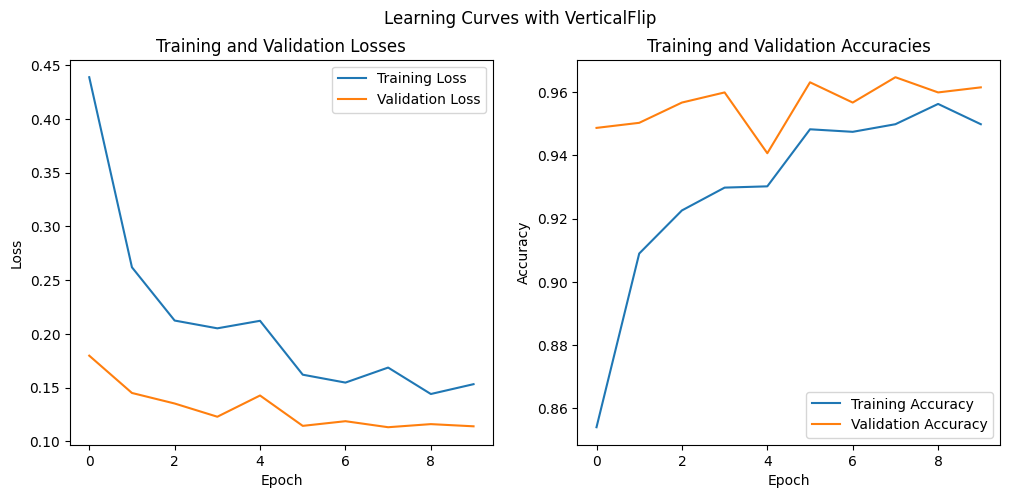

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "VerticalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "VerticalFlip")

### MixUp

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=base_transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

MixUp has poor performance on train set but the results on the validation is excellent. The reason behind this could be mixing of features and labels: in the training, we deal with mixed data that is hard to learn but in validation, we have original data which is simpler than mixed data, so our model can predict them better:

Epoch: 01
	Train Loss: 0.755 | Train Acc: 59.98% | Train F1: 59.91%
	 Val. Loss: 0.271 |  Val. Acc: 94.07% | Val F1: 94.08%
Epoch: 02
	Train Loss: 0.655 | Train Acc: 59.38% | Train F1: 59.36%
	 Val. Loss: 0.233 |  Val. Acc: 95.67% | Val F1: 95.68%
Epoch: 03
	Train Loss: 0.644 | Train Acc: 65.08% | Train F1: 65.06%
	 Val. Loss: 0.240 |  Val. Acc: 94.23% | Val F1: 94.18%
Epoch: 04
	Train Loss: 0.637 | Train Acc: 61.31% | Train F1: 61.30%
	 Val. Loss: 0.217 |  Val. Acc: 95.67% | Val F1: 95.68%
Epoch: 05
	Train Loss: 0.642 | Train Acc: 60.06% | Train F1: 60.04%
	 Val. Loss: 0.210 |  Val. Acc: 96.31% | Val F1: 96.32%
Epoch: 06
	Train Loss: 0.597 | Train Acc: 60.47% | Train F1: 60.46%
	 Val. Loss: 0.210 |  Val. Acc: 96.31% | Val F1: 96.32%
Epoch: 07
	Train Loss: 0.596 | Train Acc: 62.39% | Train F1: 62.35%
	 Val. Loss: 0.212 |  Val. Acc: 96.15% | Val F1: 96.15%
Epoch: 08
	Train Loss: 0.584 | Train Acc: 62.39% | Train F1: 62.34%
	 Val. Loss: 0.209 |  Val. Acc: 96.31% | Val F1: 96.32%
Epoch: 0

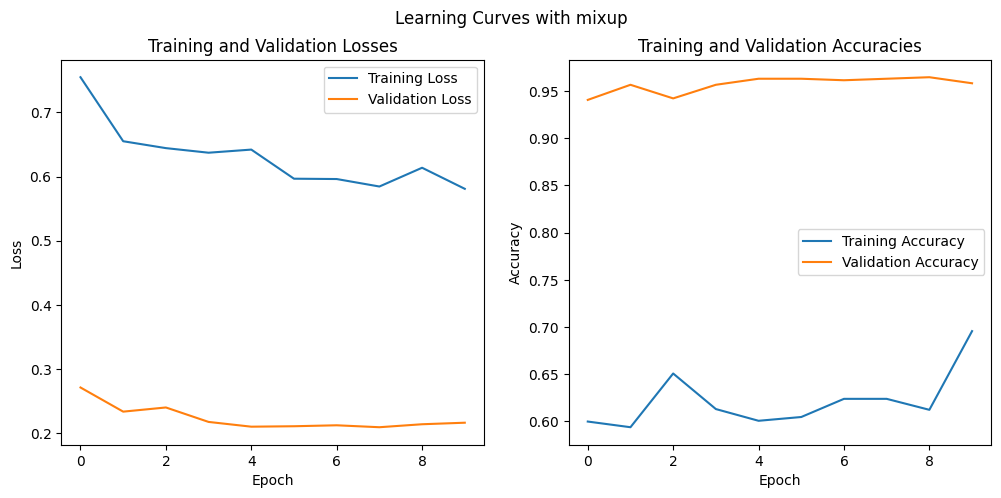

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "mixup",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "mixup")

## MobileNet-V3

Now we have MobileNet to test!

### Without any Augmentation

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

To the some point, validation has smaller than loss than train but after that all of thing changed: Train is better than validation:

Epoch: 01
	Train Loss: 0.438 | Train Acc: 86.05% | Train F1: 86.06%
	 Val. Loss: 0.214 |  Val. Acc: 93.75% | Val F1: 93.79%
Epoch: 02
	Train Loss: 0.235 | Train Acc: 91.78% | Train F1: 91.78%
	 Val. Loss: 0.187 |  Val. Acc: 95.19% | Val F1: 95.21%
Epoch: 03
	Train Loss: 0.176 | Train Acc: 94.43% | Train F1: 94.43%
	 Val. Loss: 0.173 |  Val. Acc: 93.91% | Val F1: 93.92%
Epoch: 04
	Train Loss: 0.159 | Train Acc: 94.43% | Train F1: 94.42%
	 Val. Loss: 0.170 |  Val. Acc: 93.75% | Val F1: 93.75%
Epoch: 05
	Train Loss: 0.151 | Train Acc: 94.63% | Train F1: 94.63%
	 Val. Loss: 0.166 |  Val. Acc: 94.39% | Val F1: 94.39%
Epoch: 06
	Train Loss: 0.134 | Train Acc: 95.71% | Train F1: 95.71%
	 Val. Loss: 0.161 |  Val. Acc: 94.71% | Val F1: 94.71%
Epoch: 07
	Train Loss: 0.131 | Train Acc: 95.51% | Train F1: 95.51%
	 Val. Loss: 0.160 |  Val. Acc: 95.03% | Val F1: 95.03%
Epoch: 08
	Train Loss: 0.134 | Train Acc: 95.75% | Train F1: 95.75%
	 Val. Loss: 0.159 |  Val. Acc: 94.87% | Val F1: 94.87%
Epoch: 0

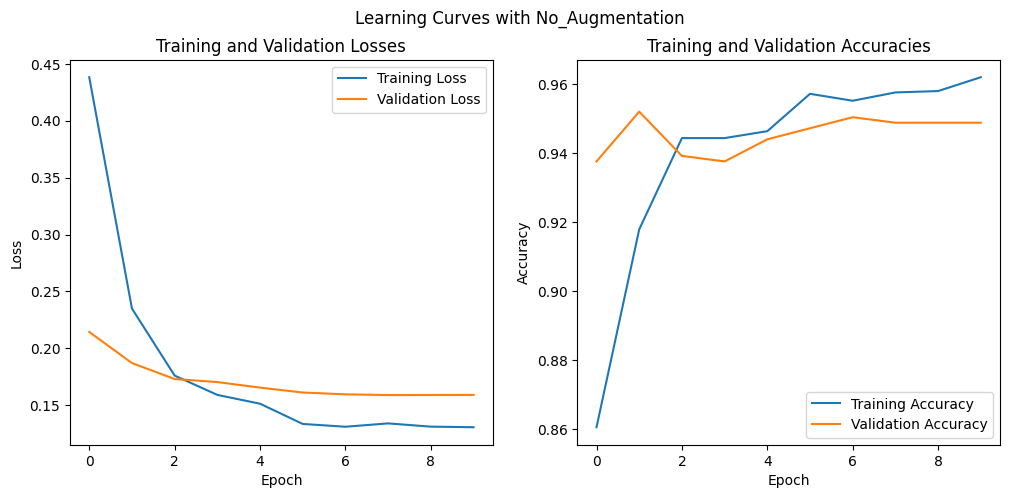

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "No_Augmentation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "No_Augmentation")

### ColorJitter

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

After 4-5 epochs, the performance of model has worsen epoch by epoch but in on the validation, it saw some slight improvements. Maybe the model is learning features that are not suitable for training data but good for validation data:



Epoch: 01
	Train Loss: 0.481 | Train Acc: 83.72% | Train F1: 83.75%
	 Val. Loss: 0.215 |  Val. Acc: 93.91% | Val F1: 93.93%
Epoch: 02
	Train Loss: 0.277 | Train Acc: 91.14% | Train F1: 91.14%
	 Val. Loss: 0.188 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 03
	Train Loss: 0.227 | Train Acc: 92.46% | Train F1: 92.46%
	 Val. Loss: 0.166 |  Val. Acc: 93.27% | Val F1: 93.30%
Epoch: 04
	Train Loss: 0.214 | Train Acc: 91.98% | Train F1: 91.98%
	 Val. Loss: 0.157 |  Val. Acc: 94.23% | Val F1: 94.25%
Epoch: 05
	Train Loss: 0.185 | Train Acc: 94.19% | Train F1: 94.18%
	 Val. Loss: 0.158 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 06
	Train Loss: 0.180 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.156 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 07
	Train Loss: 0.181 | Train Acc: 93.66% | Train F1: 93.66%
	 Val. Loss: 0.153 |  Val. Acc: 94.55% | Val F1: 94.58%
Epoch: 08
	Train Loss: 0.184 | Train Acc: 93.14% | Train F1: 93.14%
	 Val. Loss: 0.153 |  Val. Acc: 94.55% | Val F1: 94.58%
Epoch: 0

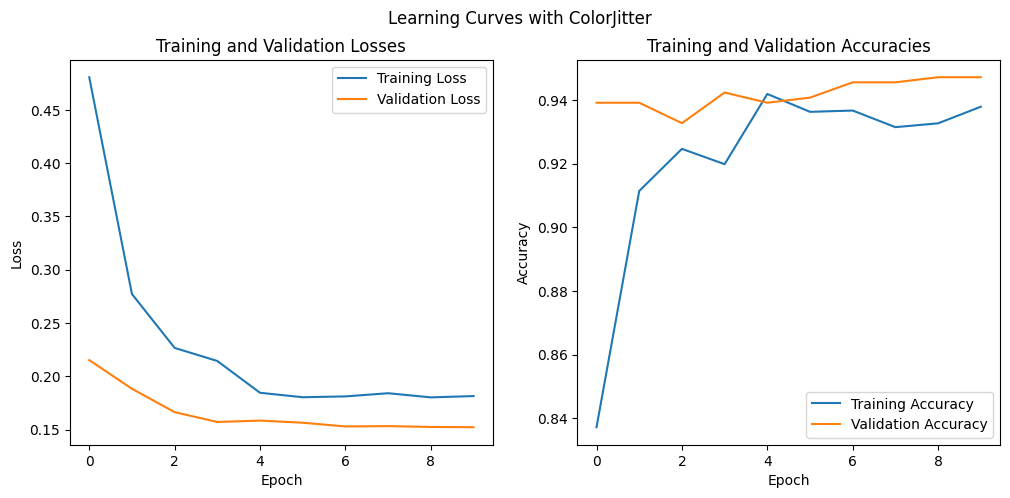

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "ColorJitter",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ColorJitter")

### RandomRotation

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_rotation,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Again train loss is higher than validation loss:

Epoch: 01
	Train Loss: 0.484 | Train Acc: 83.76% | Train F1: 83.80%
	 Val. Loss: 0.226 |  Val. Acc: 92.95% | Val F1: 92.97%
Epoch: 02
	Train Loss: 0.278 | Train Acc: 90.22% | Train F1: 90.22%
	 Val. Loss: 0.188 |  Val. Acc: 93.11% | Val F1: 93.12%
Epoch: 03
	Train Loss: 0.246 | Train Acc: 91.30% | Train F1: 91.30%
	 Val. Loss: 0.169 |  Val. Acc: 94.39% | Val F1: 94.38%
Epoch: 04
	Train Loss: 0.227 | Train Acc: 92.02% | Train F1: 92.03%
	 Val. Loss: 0.164 |  Val. Acc: 94.07% | Val F1: 94.05%
Epoch: 05
	Train Loss: 0.199 | Train Acc: 93.10% | Train F1: 93.10%
	 Val. Loss: 0.158 |  Val. Acc: 93.59% | Val F1: 93.57%
Epoch: 06
	Train Loss: 0.211 | Train Acc: 91.82% | Train F1: 91.80%
	 Val. Loss: 0.157 |  Val. Acc: 93.91% | Val F1: 93.89%
Epoch: 07
	Train Loss: 0.207 | Train Acc: 92.90% | Train F1: 92.91%
	 Val. Loss: 0.157 |  Val. Acc: 94.23% | Val F1: 94.21%
Epoch: 08
	Train Loss: 0.205 | Train Acc: 92.22% | Train F1: 92.22%
	 Val. Loss: 0.156 |  Val. Acc: 94.39% | Val F1: 94.38%
Epoch: 0

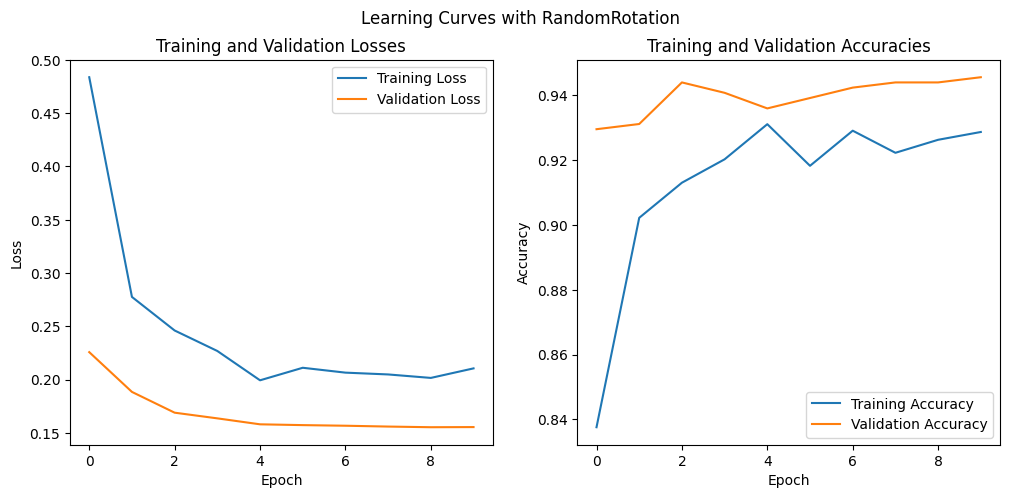

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomRotation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomRotation")

### RandomCrop

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_crop,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Althogh the trainig accuracy keeps getting better but after 5 epochs, we see overfitting and the performance on validation set is getting worse:

Epoch: 01
	Train Loss: 0.437 | Train Acc: 86.13% | Train F1: 86.14%
	 Val. Loss: 0.215 |  Val. Acc: 94.07% | Val F1: 94.09%
Epoch: 02
	Train Loss: 0.225 | Train Acc: 92.42% | Train F1: 92.42%
	 Val. Loss: 0.184 |  Val. Acc: 95.03% | Val F1: 95.04%
Epoch: 03
	Train Loss: 0.203 | Train Acc: 92.78% | Train F1: 92.78%
	 Val. Loss: 0.171 |  Val. Acc: 94.23% | Val F1: 94.25%
Epoch: 04
	Train Loss: 0.170 | Train Acc: 94.07% | Train F1: 94.07%
	 Val. Loss: 0.168 |  Val. Acc: 94.07% | Val F1: 94.09%
Epoch: 05
	Train Loss: 0.151 | Train Acc: 94.55% | Train F1: 94.54%
	 Val. Loss: 0.164 |  Val. Acc: 95.19% | Val F1: 95.20%
Epoch: 06
	Train Loss: 0.149 | Train Acc: 95.19% | Train F1: 95.19%
	 Val. Loss: 0.158 |  Val. Acc: 95.03% | Val F1: 95.04%
Epoch: 07
	Train Loss: 0.151 | Train Acc: 94.99% | Train F1: 94.99%
	 Val. Loss: 0.155 |  Val. Acc: 94.71% | Val F1: 94.71%
Epoch: 08
	Train Loss: 0.144 | Train Acc: 95.27% | Train F1: 95.27%
	 Val. Loss: 0.155 |  Val. Acc: 94.87% | Val F1: 94.86%
Epoch: 0

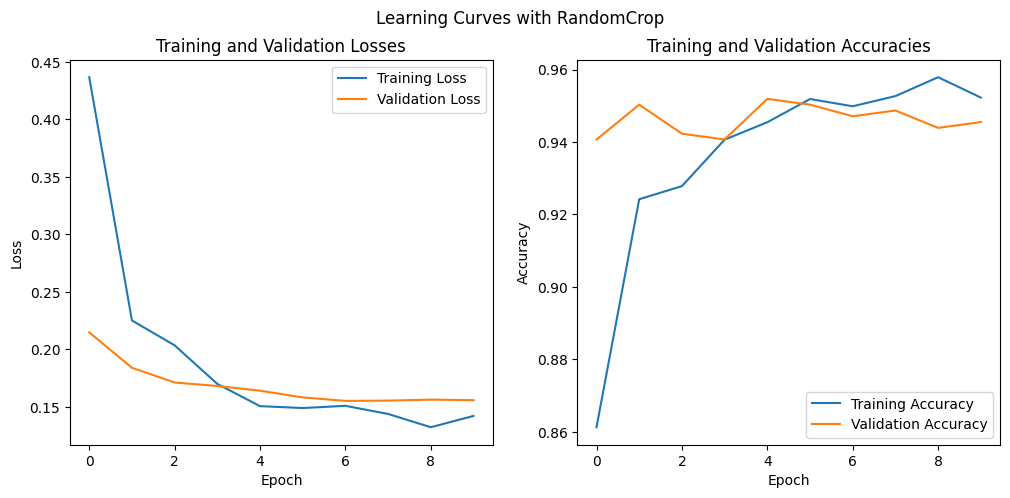

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomCrop",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomCrop")

### GaussianBlur

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        gaussian_blur,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We see overfitting in this part in the last epochs becuase both train and validation accuracy keep getting better during epochs:

Epoch: 01
	Train Loss: 0.371 | Train Acc: 90.06% | Train F1: 90.06%
	 Val. Loss: 0.204 |  Val. Acc: 93.91% | Val F1: 93.96%
Epoch: 02
	Train Loss: 0.211 | Train Acc: 93.38% | Train F1: 93.39%
	 Val. Loss: 0.188 |  Val. Acc: 93.75% | Val F1: 93.79%
Epoch: 03
	Train Loss: 0.193 | Train Acc: 93.58% | Train F1: 93.59%
	 Val. Loss: 0.173 |  Val. Acc: 94.23% | Val F1: 94.24%
Epoch: 04
	Train Loss: 0.163 | Train Acc: 94.31% | Train F1: 94.31%
	 Val. Loss: 0.163 |  Val. Acc: 94.07% | Val F1: 94.07%
Epoch: 05
	Train Loss: 0.156 | Train Acc: 94.67% | Train F1: 94.66%
	 Val. Loss: 0.157 |  Val. Acc: 94.39% | Val F1: 94.40%
Epoch: 06
	Train Loss: 0.154 | Train Acc: 94.23% | Train F1: 94.23%
	 Val. Loss: 0.153 |  Val. Acc: 94.87% | Val F1: 94.87%
Epoch: 07
	Train Loss: 0.144 | Train Acc: 95.19% | Train F1: 95.18%
	 Val. Loss: 0.151 |  Val. Acc: 95.19% | Val F1: 95.19%
Epoch: 08
	Train Loss: 0.146 | Train Acc: 94.87% | Train F1: 94.87%
	 Val. Loss: 0.150 |  Val. Acc: 95.19% | Val F1: 95.19%
Epoch: 0

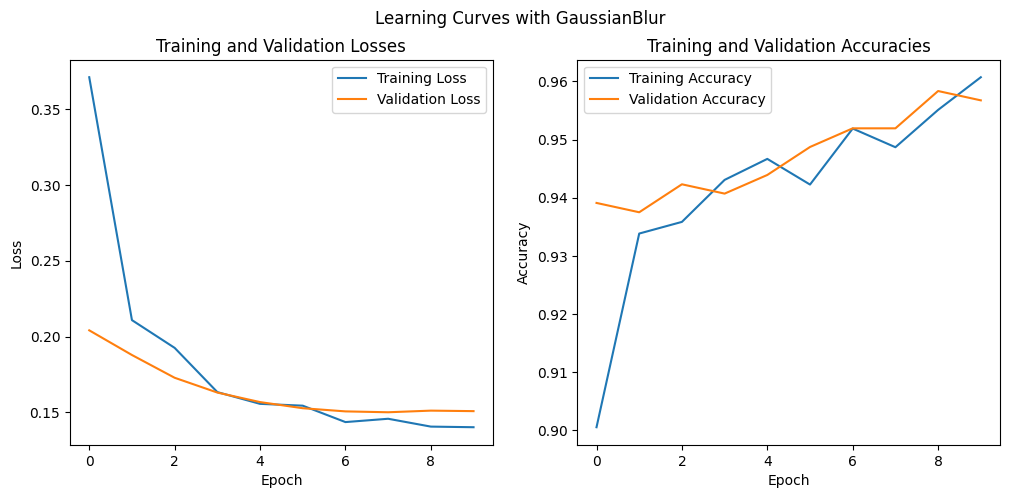

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "GaussianBlur",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "GaussianBlur")

### Grayscale

Again we have grayscale transform and the same scnearion that we observed in the past:

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        grayscale,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.496 | Train Acc: 83.56% | Train F1: 83.57%
	 Val. Loss: 0.274 |  Val. Acc: 93.11% | Val F1: 93.14%
Epoch: 02
	Train Loss: 0.291 | Train Acc: 90.34% | Train F1: 90.34%
	 Val. Loss: 0.265 |  Val. Acc: 90.38% | Val F1: 90.41%
Epoch: 03
	Train Loss: 0.249 | Train Acc: 91.58% | Train F1: 91.58%
	 Val. Loss: 0.275 |  Val. Acc: 90.06% | Val F1: 90.08%
Epoch: 04
	Train Loss: 0.230 | Train Acc: 92.26% | Train F1: 92.25%
	 Val. Loss: 0.306 |  Val. Acc: 88.78% | Val F1: 88.79%
Epoch: 05
	Train Loss: 0.210 | Train Acc: 92.86% | Train F1: 92.86%
	 Val. Loss: 0.374 |  Val. Acc: 85.42% | Val F1: 85.40%
Epoch: 06
	Train Loss: 0.190 | Train Acc: 93.99% | Train F1: 93.98%
	 Val. Loss: 0.495 |  Val. Acc: 80.13% | Val F1: 80.14%
Epoch: 07
	Train Loss: 0.191 | Train Acc: 93.42% | Train F1: 93.42%
	 Val. Loss: 0.663 |  Val. Acc: 72.92% | Val F1: 72.74%
Epoch: 08
	Train Loss: 0.192 | Train Acc: 93.83% | Train F1: 93.83%
	 Val. Loss: 0.881 |  Val. Acc: 64.42% | Val F1: 63.38%
Epoch: 0

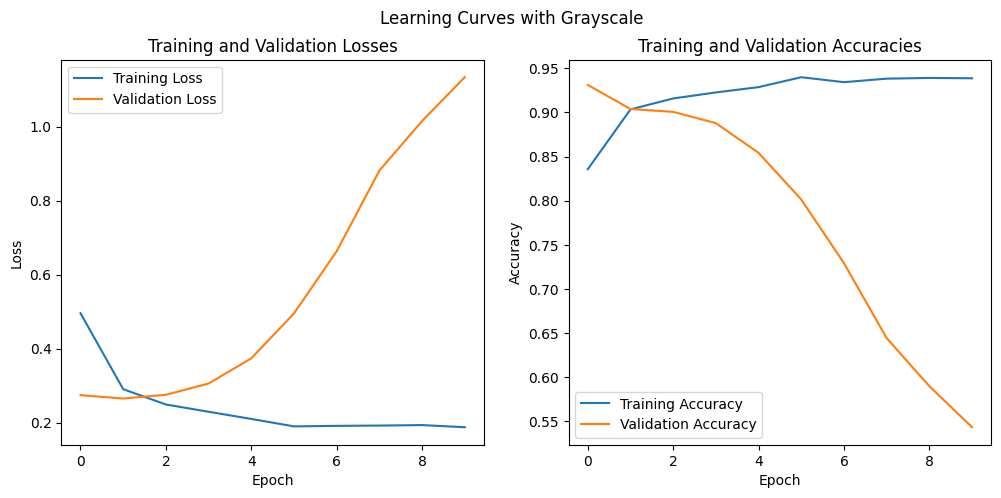

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "Grayscale",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Grayscale")

### RandomHorizontalFlip

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        horizontal_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Here training and validation accuracy are too close to each other but after 6 or 7 epochs their improvement is too slight:

Epoch: 01
	Train Loss: 0.448 | Train Acc: 84.80% | Train F1: 84.80%
	 Val. Loss: 0.213 |  Val. Acc: 93.59% | Val F1: 93.64%
Epoch: 02
	Train Loss: 0.224 | Train Acc: 93.10% | Train F1: 93.11%
	 Val. Loss: 0.181 |  Val. Acc: 94.71% | Val F1: 94.73%
Epoch: 03
	Train Loss: 0.187 | Train Acc: 93.58% | Train F1: 93.58%
	 Val. Loss: 0.167 |  Val. Acc: 94.55% | Val F1: 94.56%
Epoch: 04
	Train Loss: 0.166 | Train Acc: 94.75% | Train F1: 94.75%
	 Val. Loss: 0.161 |  Val. Acc: 94.39% | Val F1: 94.39%
Epoch: 05
	Train Loss: 0.157 | Train Acc: 94.63% | Train F1: 94.63%
	 Val. Loss: 0.157 |  Val. Acc: 94.23% | Val F1: 94.24%
Epoch: 06
	Train Loss: 0.152 | Train Acc: 95.27% | Train F1: 95.27%
	 Val. Loss: 0.152 |  Val. Acc: 95.19% | Val F1: 95.20%
Epoch: 07
	Train Loss: 0.141 | Train Acc: 95.39% | Train F1: 95.39%
	 Val. Loss: 0.149 |  Val. Acc: 95.51% | Val F1: 95.51%
Epoch: 08
	Train Loss: 0.139 | Train Acc: 95.55% | Train F1: 95.55%
	 Val. Loss: 0.148 |  Val. Acc: 95.51% | Val F1: 95.51%
Epoch: 0

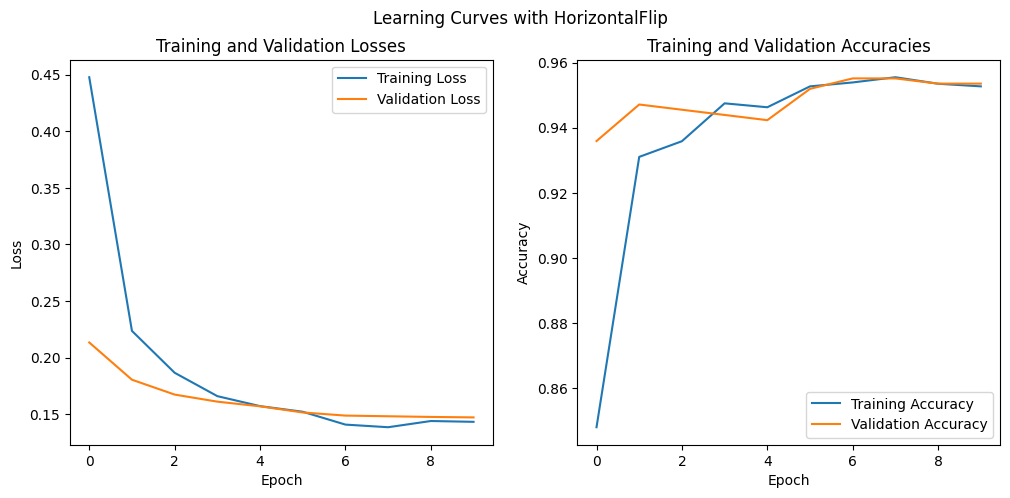

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "HorizontalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "HorizontalFlip")

### RandomVerticalFlip

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        vertical_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Like many of the previous cases!

Epoch: 01
	Train Loss: 0.475 | Train Acc: 84.12% | Train F1: 84.10%
	 Val. Loss: 0.219 |  Val. Acc: 93.91% | Val F1: 93.95%
Epoch: 02
	Train Loss: 0.252 | Train Acc: 91.82% | Train F1: 91.82%
	 Val. Loss: 0.191 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 03
	Train Loss: 0.214 | Train Acc: 92.26% | Train F1: 92.27%
	 Val. Loss: 0.174 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 04
	Train Loss: 0.200 | Train Acc: 93.54% | Train F1: 93.55%
	 Val. Loss: 0.166 |  Val. Acc: 94.55% | Val F1: 94.56%
Epoch: 05
	Train Loss: 0.187 | Train Acc: 93.79% | Train F1: 93.79%
	 Val. Loss: 0.160 |  Val. Acc: 94.87% | Val F1: 94.88%
Epoch: 06
	Train Loss: 0.182 | Train Acc: 93.66% | Train F1: 93.66%
	 Val. Loss: 0.158 |  Val. Acc: 95.51% | Val F1: 95.53%
Epoch: 07
	Train Loss: 0.168 | Train Acc: 94.43% | Train F1: 94.43%
	 Val. Loss: 0.157 |  Val. Acc: 95.35% | Val F1: 95.36%
Epoch: 08
	Train Loss: 0.180 | Train Acc: 93.99% | Train F1: 93.98%
	 Val. Loss: 0.156 |  Val. Acc: 95.51% | Val F1: 95.52%
Epoch: 0

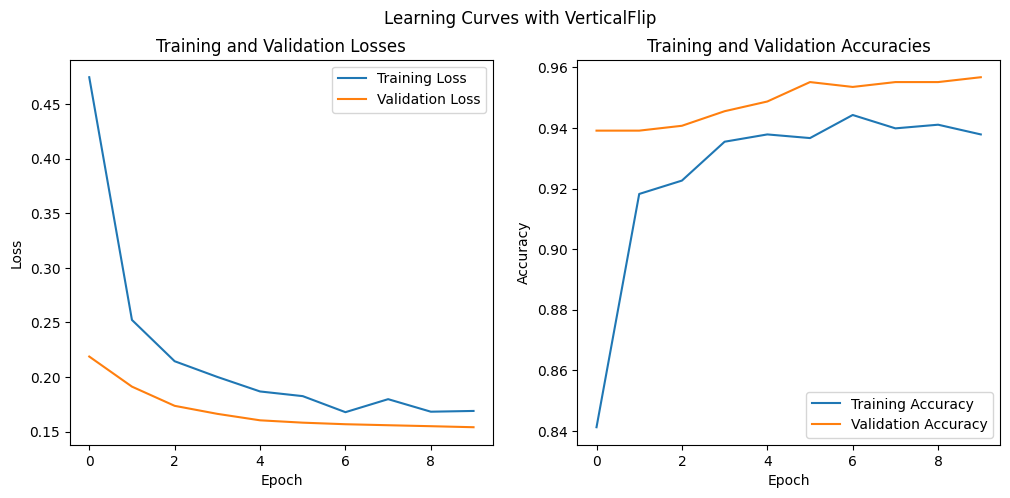

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "VerticalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "VerticalFlip")

### MixUp

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=base_transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Here we saw the same behavior from MixUp same as before:

Epoch: 01
	Train Loss: 0.750 | Train Acc: 59.58% | Train F1: 59.46%
	 Val. Loss: 0.304 |  Val. Acc: 93.27% | Val F1: 93.29%
Epoch: 02
	Train Loss: 0.660 | Train Acc: 64.84% | Train F1: 64.82%
	 Val. Loss: 0.325 |  Val. Acc: 93.43% | Val F1: 93.44%
Epoch: 03
	Train Loss: 0.636 | Train Acc: 63.63% | Train F1: 63.59%
	 Val. Loss: 0.323 |  Val. Acc: 92.31% | Val F1: 92.31%
Epoch: 04
	Train Loss: 0.587 | Train Acc: 61.31% | Train F1: 61.26%
	 Val. Loss: 0.287 |  Val. Acc: 93.59% | Val F1: 93.60%
Epoch: 05
	Train Loss: 0.580 | Train Acc: 63.75% | Train F1: 63.72%
	 Val. Loss: 0.264 |  Val. Acc: 95.19% | Val F1: 95.19%
Epoch: 06
	Train Loss: 0.618 | Train Acc: 64.51% | Train F1: 64.50%
	 Val. Loss: 0.264 |  Val. Acc: 94.55% | Val F1: 94.56%
Epoch: 07
	Train Loss: 0.608 | Train Acc: 60.63% | Train F1: 60.62%
	 Val. Loss: 0.269 |  Val. Acc: 94.39% | Val F1: 94.39%
Epoch: 08
	Train Loss: 0.618 | Train Acc: 61.95% | Train F1: 61.94%
	 Val. Loss: 0.274 |  Val. Acc: 94.55% | Val F1: 94.55%
Epoch: 0

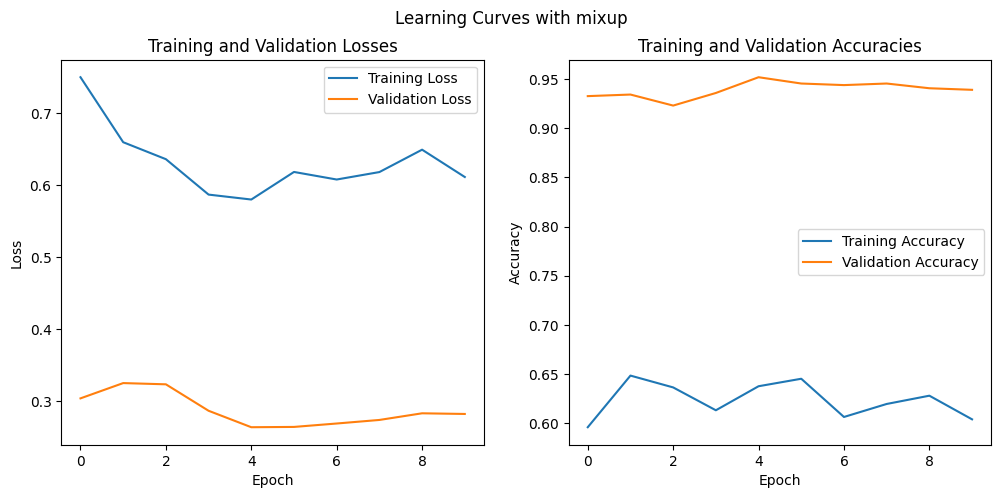

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "mixup",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "mixup")

## Custom CNN

In this network, becuase we train all the weights from scratch, we expect to observe more ups and downs in accuracy and loss because changes in all of the weights can bring more unexpected events to us:



### Without any Augmentation

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We have an stable learning curve for training but suddenly at some point we observe a drop in validation accuracy. It happens becuase of batch learning and the fact of training whole network:

Epoch: 01
	Train Loss: 0.852 | Train Acc: 68.56% | Train F1: 68.55%
	 Val. Loss: 0.868 |  Val. Acc: 66.67% | Val F1: 64.91%
Epoch: 02
	Train Loss: 0.769 | Train Acc: 77.31% | Train F1: 77.45%
	 Val. Loss: 0.854 |  Val. Acc: 67.63% | Val F1: 60.11%
Epoch: 03
	Train Loss: 0.757 | Train Acc: 79.31% | Train F1: 79.44%
	 Val. Loss: 1.022 |  Val. Acc: 50.16% | Val F1: 40.75%
Epoch: 04
	Train Loss: 0.735 | Train Acc: 81.28% | Train F1: 81.34%
	 Val. Loss: 0.763 |  Val. Acc: 77.72% | Val F1: 77.41%
Epoch: 05
	Train Loss: 0.724 | Train Acc: 82.20% | Train F1: 82.24%
	 Val. Loss: 0.694 |  Val. Acc: 85.10% | Val F1: 84.77%
Epoch: 06
	Train Loss: 0.701 | Train Acc: 84.76% | Train F1: 84.87%
	 Val. Loss: 0.667 |  Val. Acc: 88.78% | Val F1: 88.83%
Epoch: 07
	Train Loss: 0.678 | Train Acc: 86.85% | Train F1: 86.88%
	 Val. Loss: 0.658 |  Val. Acc: 89.10% | Val F1: 89.13%
Epoch: 08
	Train Loss: 0.679 | Train Acc: 87.13% | Train F1: 87.15%
	 Val. Loss: 0.655 |  Val. Acc: 89.10% | Val F1: 89.09%
Epoch: 0

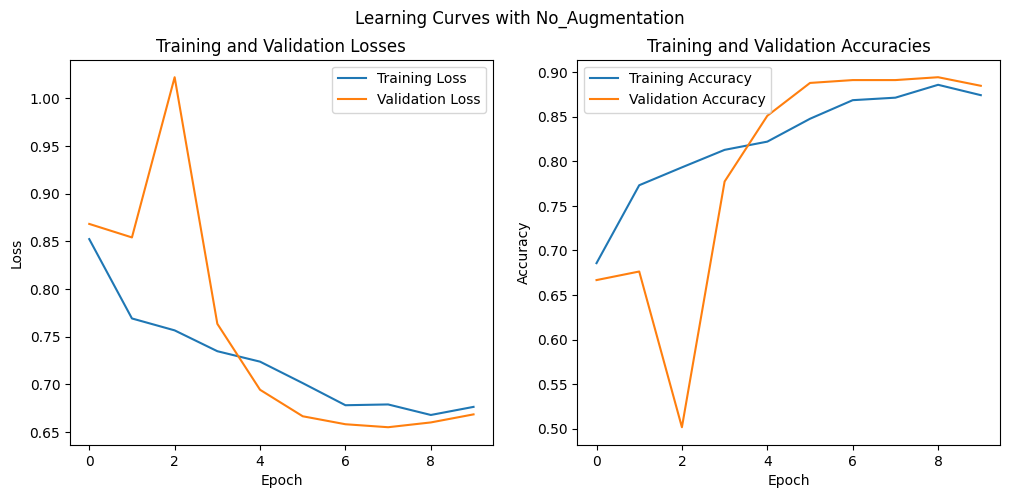

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "No_Augmentation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "No_Augmentation")

### ColorJitter

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Again we see ups and downs in model training on validation data:

Epoch: 01
	Train Loss: 0.880 | Train Acc: 65.96% | Train F1: 66.01%
	 Val. Loss: 0.811 |  Val. Acc: 74.52% | Val F1: 74.95%
Epoch: 02
	Train Loss: 0.800 | Train Acc: 74.46% | Train F1: 74.59%
	 Val. Loss: 0.774 |  Val. Acc: 77.56% | Val F1: 77.46%
Epoch: 03
	Train Loss: 0.774 | Train Acc: 77.27% | Train F1: 77.43%
	 Val. Loss: 0.772 |  Val. Acc: 78.69% | Val F1: 78.61%
Epoch: 04
	Train Loss: 0.770 | Train Acc: 77.19% | Train F1: 77.28%
	 Val. Loss: 0.790 |  Val. Acc: 75.32% | Val F1: 75.63%
Epoch: 05
	Train Loss: 0.761 | Train Acc: 78.23% | Train F1: 78.34%
	 Val. Loss: 0.778 |  Val. Acc: 76.76% | Val F1: 76.47%
Epoch: 06
	Train Loss: 0.727 | Train Acc: 82.08% | Train F1: 82.16%
	 Val. Loss: 0.689 |  Val. Acc: 85.90% | Val F1: 86.04%
Epoch: 07
	Train Loss: 0.724 | Train Acc: 82.60% | Train F1: 82.71%
	 Val. Loss: 0.677 |  Val. Acc: 88.62% | Val F1: 88.73%
Epoch: 08
	Train Loss: 0.710 | Train Acc: 83.84% | Train F1: 83.94%
	 Val. Loss: 0.683 |  Val. Acc: 86.54% | Val F1: 86.50%
Epoch: 0

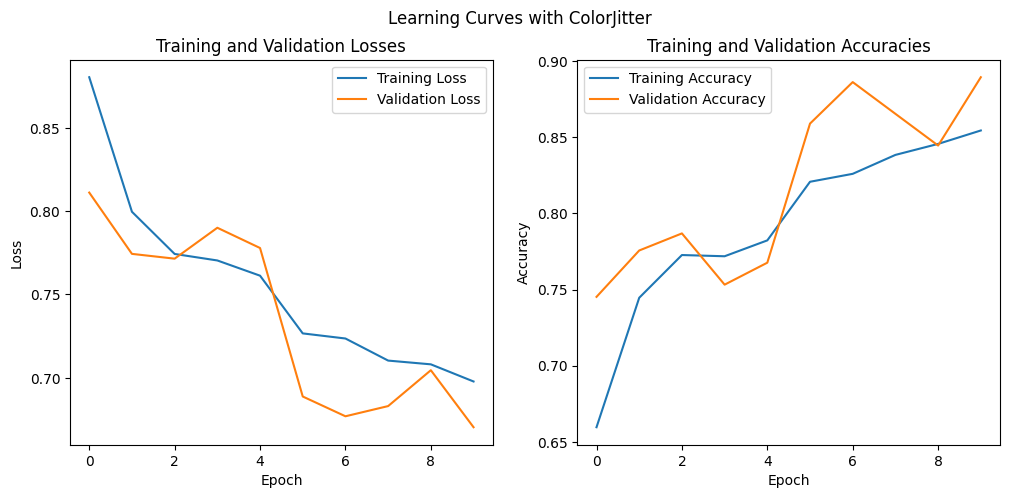

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "ColorJitter",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ColorJitter")

### RandomRotation

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_rotation,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

The performance of random rotation is worse than the last methods:

Epoch: 01
	Train Loss: 0.860 | Train Acc: 68.28% | Train F1: 68.25%
	 Val. Loss: 0.815 |  Val. Acc: 72.92% | Val F1: 73.30%
Epoch: 02
	Train Loss: 0.812 | Train Acc: 73.30% | Train F1: 73.37%
	 Val. Loss: 0.865 |  Val. Acc: 65.87% | Val F1: 63.54%
Epoch: 03
	Train Loss: 0.797 | Train Acc: 74.70% | Train F1: 74.83%
	 Val. Loss: 0.944 |  Val. Acc: 59.78% | Val F1: 49.93%
Epoch: 04
	Train Loss: 0.780 | Train Acc: 76.22% | Train F1: 76.26%
	 Val. Loss: 0.738 |  Val. Acc: 80.61% | Val F1: 80.86%
Epoch: 05
	Train Loss: 0.778 | Train Acc: 76.66% | Train F1: 76.67%
	 Val. Loss: 0.898 |  Val. Acc: 65.06% | Val F1: 59.92%
Epoch: 06
	Train Loss: 0.737 | Train Acc: 81.03% | Train F1: 81.26%
	 Val. Loss: 0.698 |  Val. Acc: 84.62% | Val F1: 84.72%
Epoch: 07
	Train Loss: 0.734 | Train Acc: 81.36% | Train F1: 81.45%
	 Val. Loss: 0.685 |  Val. Acc: 85.26% | Val F1: 85.32%
Epoch: 08
	Train Loss: 0.727 | Train Acc: 82.20% | Train F1: 82.30%
	 Val. Loss: 0.696 |  Val. Acc: 85.42% | Val F1: 85.50%
Epoch: 0

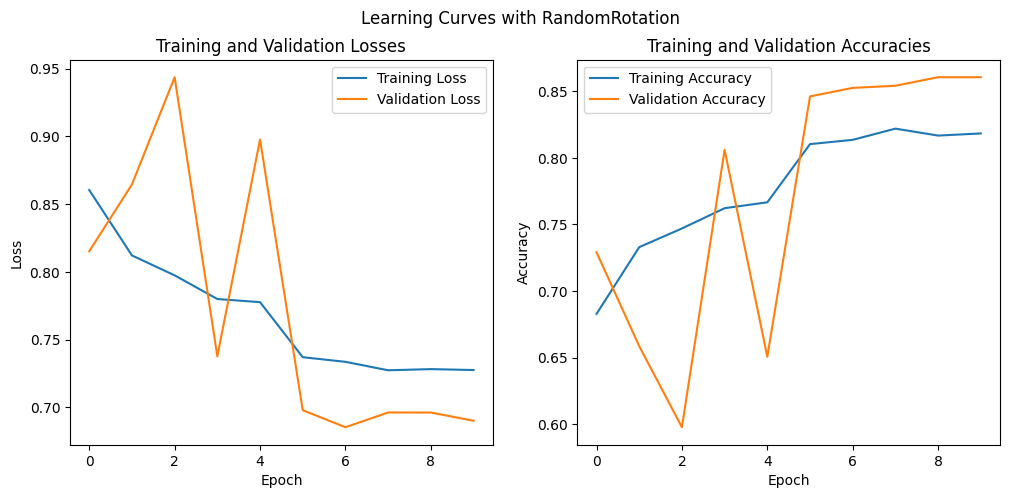

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomRotation",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomRotation")

### RandomCrop

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        random_crop,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Same as the others!

Epoch: 01
	Train Loss: 0.857 | Train Acc: 68.08% | Train F1: 67.83%
	 Val. Loss: 0.837 |  Val. Acc: 69.71% | Val F1: 68.72%
Epoch: 02
	Train Loss: 0.776 | Train Acc: 77.11% | Train F1: 77.30%
	 Val. Loss: 0.879 |  Val. Acc: 66.35% | Val F1: 62.50%
Epoch: 03
	Train Loss: 0.760 | Train Acc: 78.75% | Train F1: 78.88%
	 Val. Loss: 0.801 |  Val. Acc: 73.88% | Val F1: 71.90%
Epoch: 04
	Train Loss: 0.739 | Train Acc: 81.11% | Train F1: 81.18%
	 Val. Loss: 0.726 |  Val. Acc: 81.57% | Val F1: 81.37%
Epoch: 05
	Train Loss: 0.725 | Train Acc: 82.00% | Train F1: 82.02%
	 Val. Loss: 1.014 |  Val. Acc: 53.69% | Val F1: 44.62%
Epoch: 06
	Train Loss: 0.734 | Train Acc: 81.23% | Train F1: 81.40%
	 Val. Loss: 0.688 |  Val. Acc: 86.06% | Val F1: 86.06%
Epoch: 07
	Train Loss: 0.700 | Train Acc: 85.12% | Train F1: 85.14%
	 Val. Loss: 0.665 |  Val. Acc: 88.94% | Val F1: 88.89%
Epoch: 08
	Train Loss: 0.686 | Train Acc: 86.45% | Train F1: 86.49%
	 Val. Loss: 0.664 |  Val. Acc: 89.42% | Val F1: 89.45%
Epoch: 0

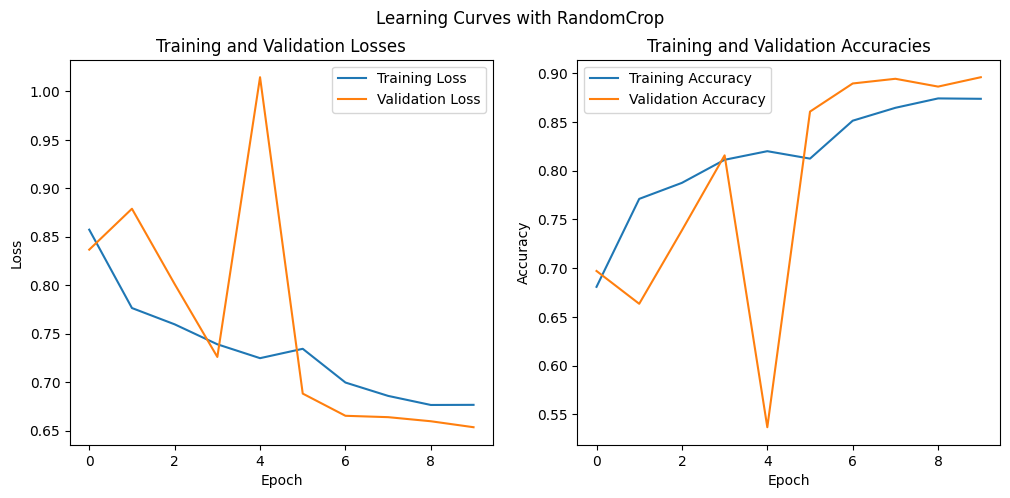

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "RandomCrop",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RandomCrop")

### GaussianBlur

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        gaussian_blur,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Again the same story!

Epoch: 01
	Train Loss: 0.834 | Train Acc: 70.89% | Train F1: 70.81%
	 Val. Loss: 0.803 |  Val. Acc: 73.88% | Val F1: 71.91%
Epoch: 02
	Train Loss: 0.775 | Train Acc: 77.47% | Train F1: 77.59%
	 Val. Loss: 0.868 |  Val. Acc: 66.99% | Val F1: 62.81%
Epoch: 03
	Train Loss: 0.755 | Train Acc: 78.67% | Train F1: 78.70%
	 Val. Loss: 0.853 |  Val. Acc: 68.91% | Val F1: 66.21%
Epoch: 04
	Train Loss: 0.745 | Train Acc: 79.83% | Train F1: 79.88%
	 Val. Loss: 0.728 |  Val. Acc: 82.21% | Val F1: 82.60%
Epoch: 05
	Train Loss: 0.730 | Train Acc: 81.80% | Train F1: 81.90%
	 Val. Loss: 0.761 |  Val. Acc: 77.88% | Val F1: 77.22%
Epoch: 06
	Train Loss: 0.697 | Train Acc: 85.32% | Train F1: 85.33%
	 Val. Loss: 0.657 |  Val. Acc: 89.26% | Val F1: 89.29%
Epoch: 07
	Train Loss: 0.688 | Train Acc: 86.13% | Train F1: 86.15%
	 Val. Loss: 0.652 |  Val. Acc: 89.90% | Val F1: 89.92%
Epoch: 08
	Train Loss: 0.687 | Train Acc: 86.05% | Train F1: 86.08%
	 Val. Loss: 0.657 |  Val. Acc: 89.42% | Val F1: 89.45%
Epoch: 0

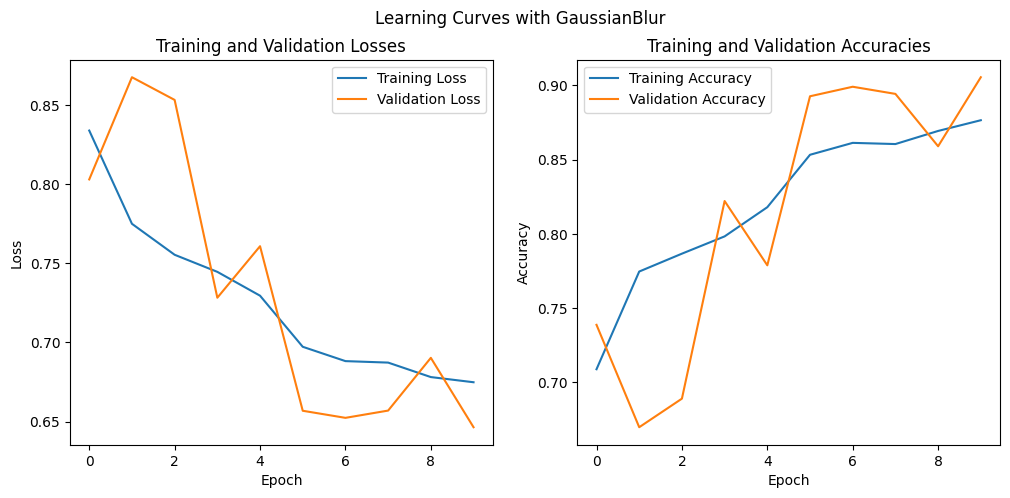

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "GaussianBlur",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "GaussianBlur")

### Grayscale

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        grayscale,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Because of Grayscale, again we have some drop in model performance in validation part:

Epoch: 01
	Train Loss: 0.879 | Train Acc: 65.84% | Train F1: 65.77%
	 Val. Loss: 0.918 |  Val. Acc: 61.54% | Val F1: 57.81%
Epoch: 02
	Train Loss: 0.814 | Train Acc: 73.22% | Train F1: 73.18%
	 Val. Loss: 0.935 |  Val. Acc: 60.74% | Val F1: 56.61%
Epoch: 03
	Train Loss: 0.778 | Train Acc: 77.06% | Train F1: 77.23%
	 Val. Loss: 0.964 |  Val. Acc: 58.49% | Val F1: 49.42%
Epoch: 04
	Train Loss: 0.775 | Train Acc: 77.02% | Train F1: 77.00%
	 Val. Loss: 0.781 |  Val. Acc: 76.92% | Val F1: 76.66%
Epoch: 05
	Train Loss: 0.758 | Train Acc: 78.75% | Train F1: 78.83%
	 Val. Loss: 0.982 |  Val. Acc: 56.25% | Val F1: 49.03%
Epoch: 06
	Train Loss: 0.723 | Train Acc: 82.72% | Train F1: 82.74%
	 Val. Loss: 0.741 |  Val. Acc: 80.29% | Val F1: 80.14%
Epoch: 07
	Train Loss: 0.704 | Train Acc: 84.84% | Train F1: 84.89%
	 Val. Loss: 0.778 |  Val. Acc: 77.40% | Val F1: 76.48%
Epoch: 08
	Train Loss: 0.708 | Train Acc: 84.28% | Train F1: 84.33%
	 Val. Loss: 0.737 |  Val. Acc: 80.61% | Val F1: 80.56%
Epoch: 0

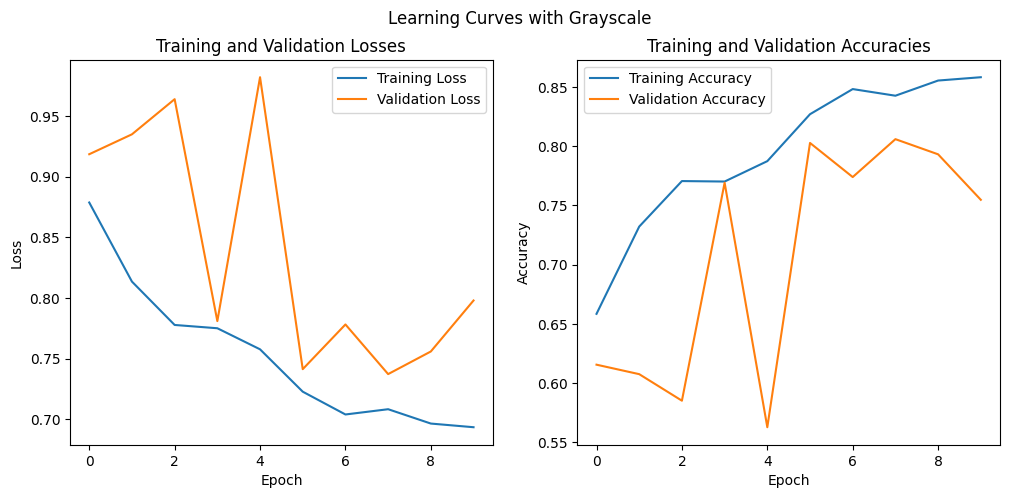

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "Grayscale",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Grayscale")

### RandomHorizontalFlip

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        horizontal_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Same!

Epoch: 01
	Train Loss: 0.802 | Train Acc: 75.30% | Train F1: 75.45%
	 Val. Loss: 0.823 |  Val. Acc: 71.15% | Val F1: 69.20%
Epoch: 02
	Train Loss: 0.777 | Train Acc: 76.94% | Train F1: 77.17%
	 Val. Loss: 0.960 |  Val. Acc: 59.29% | Val F1: 50.99%
Epoch: 03
	Train Loss: 0.744 | Train Acc: 80.31% | Train F1: 80.38%
	 Val. Loss: 0.982 |  Val. Acc: 56.41% | Val F1: 48.72%
Epoch: 04
	Train Loss: 0.735 | Train Acc: 81.11% | Train F1: 81.23%
	 Val. Loss: 0.721 |  Val. Acc: 83.01% | Val F1: 83.04%
Epoch: 05
	Train Loss: 0.745 | Train Acc: 80.03% | Train F1: 80.24%
	 Val. Loss: 0.985 |  Val. Acc: 55.29% | Val F1: 44.50%
Epoch: 06
	Train Loss: 0.704 | Train Acc: 84.84% | Train F1: 84.89%
	 Val. Loss: 0.682 |  Val. Acc: 87.02% | Val F1: 87.11%
Epoch: 07
	Train Loss: 0.689 | Train Acc: 86.29% | Train F1: 86.30%
	 Val. Loss: 0.685 |  Val. Acc: 86.70% | Val F1: 86.46%
Epoch: 08
	Train Loss: 0.677 | Train Acc: 87.21% | Train F1: 87.26%
	 Val. Loss: 0.678 |  Val. Acc: 87.18% | Val F1: 87.31%
Epoch: 0

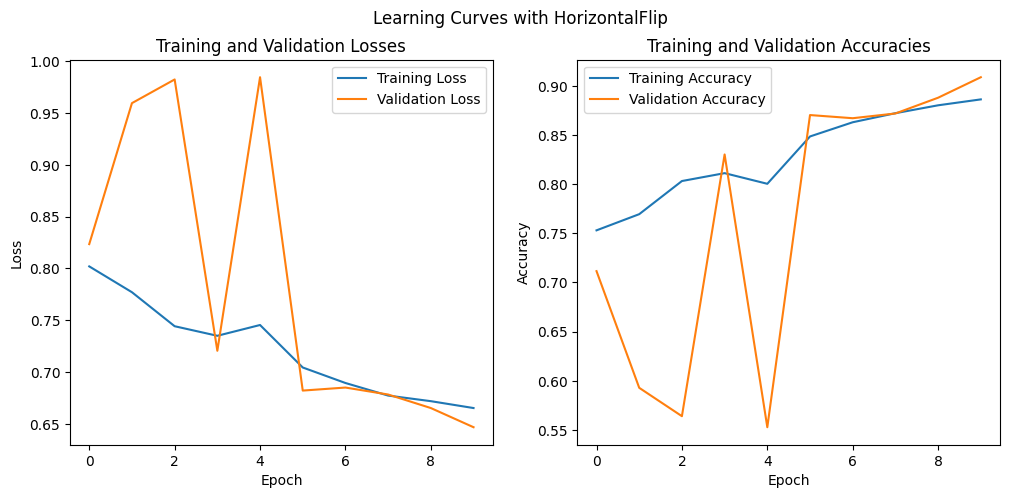

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "HorizontalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "HorizontalFlip")

### RandomVerticalFlip

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
transform = transforms.Compose([
        vertical_flip,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Again Same!

Epoch: 01
	Train Loss: 0.842 | Train Acc: 70.21% | Train F1: 70.21%
	 Val. Loss: 1.007 |  Val. Acc: 54.17% | Val F1: 46.19%
Epoch: 02
	Train Loss: 0.766 | Train Acc: 78.35% | Train F1: 78.43%
	 Val. Loss: 0.816 |  Val. Acc: 71.96% | Val F1: 69.01%
Epoch: 03
	Train Loss: 0.751 | Train Acc: 79.79% | Train F1: 79.99%
	 Val. Loss: 0.902 |  Val. Acc: 64.26% | Val F1: 60.07%
Epoch: 04
	Train Loss: 0.765 | Train Acc: 77.83% | Train F1: 77.85%
	 Val. Loss: 0.708 |  Val. Acc: 85.10% | Val F1: 84.91%
Epoch: 05
	Train Loss: 0.740 | Train Acc: 80.99% | Train F1: 81.07%
	 Val. Loss: 0.894 |  Val. Acc: 65.54% | Val F1: 60.27%
Epoch: 06
	Train Loss: 0.714 | Train Acc: 83.76% | Train F1: 83.84%
	 Val. Loss: 0.677 |  Val. Acc: 87.82% | Val F1: 87.87%
Epoch: 07
	Train Loss: 0.700 | Train Acc: 84.88% | Train F1: 84.88%
	 Val. Loss: 0.708 |  Val. Acc: 83.33% | Val F1: 83.26%
Epoch: 08
	Train Loss: 0.701 | Train Acc: 84.72% | Train F1: 84.75%
	 Val. Loss: 0.686 |  Val. Acc: 85.90% | Val F1: 85.68%
Epoch: 0

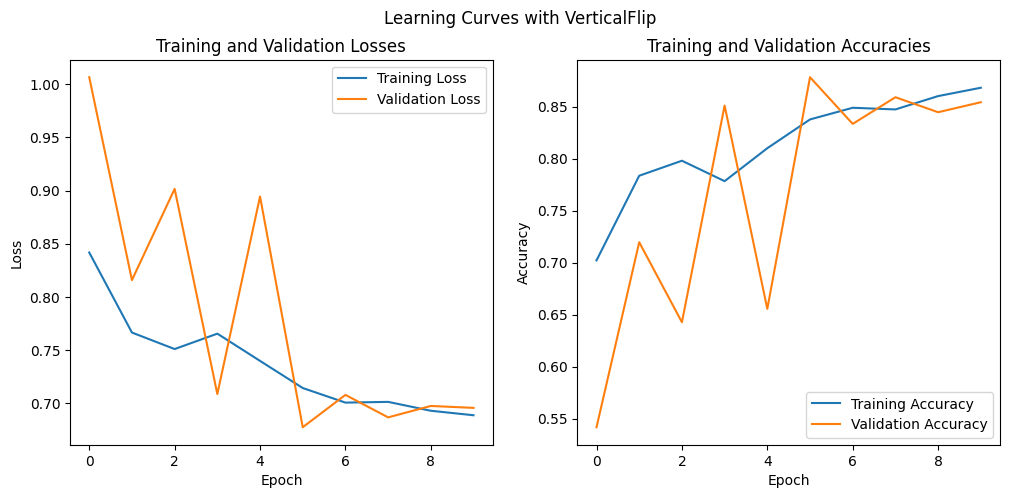

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "VerticalFlip",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "VerticalFlip")

### MixUp

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=base_transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We observe the behavior that we expect from MixUp: not so good on train, promising on validation

Epoch: 01
	Train Loss: 0.937 | Train Acc: 53.97% | Train F1: 53.85%
	 Val. Loss: 0.921 |  Val. Acc: 61.38% | Val F1: 50.33%
Epoch: 02
	Train Loss: 0.887 | Train Acc: 53.29% | Train F1: 53.32%
	 Val. Loss: 0.788 |  Val. Acc: 75.96% | Val F1: 75.55%
Epoch: 03
	Train Loss: 0.859 | Train Acc: 56.26% | Train F1: 56.25%
	 Val. Loss: 0.736 |  Val. Acc: 81.89% | Val F1: 81.97%
Epoch: 04
	Train Loss: 0.862 | Train Acc: 59.38% | Train F1: 59.42%
	 Val. Loss: 0.776 |  Val. Acc: 77.24% | Val F1: 75.77%
Epoch: 05
	Train Loss: 0.849 | Train Acc: 57.82% | Train F1: 57.81%
	 Val. Loss: 0.680 |  Val. Acc: 86.70% | Val F1: 86.61%
Epoch: 06
	Train Loss: 0.831 | Train Acc: 55.41% | Train F1: 55.40%
	 Val. Loss: 0.671 |  Val. Acc: 88.30% | Val F1: 88.21%
Epoch: 07
	Train Loss: 0.816 | Train Acc: 60.71% | Train F1: 60.70%
	 Val. Loss: 0.662 |  Val. Acc: 89.26% | Val F1: 89.26%
Epoch: 08
	Train Loss: 0.820 | Train Acc: 59.90% | Train F1: 59.90%
	 Val. Loss: 0.657 |  Val. Acc: 90.38% | Val F1: 90.38%
Epoch: 0

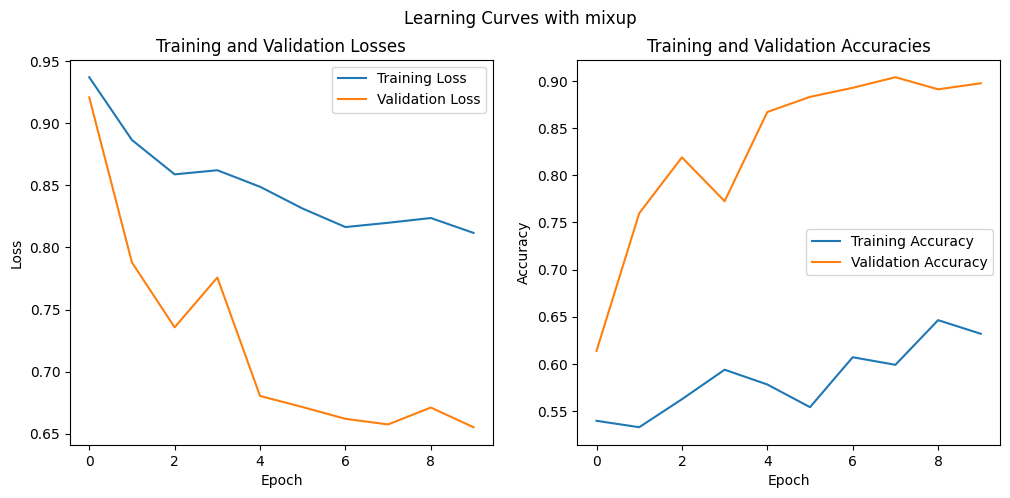

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_transforms(model,
                                                                       train_loader,
                                                                       val_loader,
                                                                       criterion,
                                                                       optimizer,
                                                                       scheduler,
                                                                       "mixup",
                                                                       num_epochs)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "mixup")

Now we are done with augmentation methods. These are the summary of the points we learned from these experiments:


*   Among different networks, ResNet-152 had a better performance. MobileNet is not a well as ResNet-152 and Custom CNN has many ups and downs in training.
*   We can't see such a big difference between different transforms and even training without any transform but two of them had special conditions: **Grayscale** will cause performance drop on validation but promising results on training. It is because of the fact that with Grayscale the info about colors will be removed and the model will overfit on text data.
*   MixUp will harden the process of training and our performance is not good on it but it is suitable for validation because now we have a more robust model.



# Optimization Algorithm

Time for trying optimization algorithms!

In [ ]:
def train_model_with_optimizer(model, train_loader, val_loader, criterion, optimizer, scheduler, transform=None, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    opt_name = optimizer.__class__.__name__

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train = []
        all_predictions_train = []

        for inputs, labels  in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            if transform == 'mixup':
                mixup_inputs, mixup_labels = mixup_data(inputs, labels, num_classes=3)
                outputs = model(mixup_inputs)
                loss = criterion(outputs, mixup_labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            if opt_name == 'SAM':
                # SAM needs two steps
                # first forward-backward pass
                optimizer.first_step(zero_grad=True)

                # second forward-backward pass
                criterion(model(inputs), labels).backward()  # make sure to do a full forward pass
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_predictions_train.extend(predicted_train.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy_train = correct_train / total_train
        train_accuracies.append(epoch_accuracy_train)

        # Calculate F1 score
        f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        all_labels_val = []
        all_predictions_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs_val = model(inputs)
                loss_val = criterion(outputs_val, labels)
                running_loss_val += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_predictions_val.extend(predicted_val.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        val_losses.append(epoch_loss_val)
        epoch_accuracy_val = correct_val / total_val
        val_accuracies.append(epoch_accuracy_val)

        # Calculate F1 score
        f1_val = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # Update learning rate
        scheduler.step()

        # Print and store results for analysis
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy_train*100:.2f}% | Train F1: {f1_train*100:.2f}%')
        print(f'\t Val. Loss: {epoch_loss_val:.3f} |  Val. Acc: {epoch_accuracy_val*100:.2f}% | Val F1: {f1_val*100:.2f}%')


    # Save the model weights after training
    torch.save(model.state_dict(), f'{model_save_path}/{model._get_name()}_{optimizer.__class__.__name__}.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

In all of our experiments, we use ColorJitter as our base transform and StepLR as our learning rate scheduler:

## ResNet-152

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is a variant of the Gradient Descent algorithm that is used for optimizing machine learning models. It addresses the computational inefficiency of traditional Gradient Descent methods when dealing with large datasets in machine learning projects.

In SGD, instead of using the entire dataset for each iteration, only a single random training example (or a small batch) is selected to calculate the gradient and update the model parameters. This random selection introduces randomness into the optimization process, hence the term “stochastic” in stochastic Gradient Descent.
![](https://media.geeksforgeeks.org/wp-content/uploads/sgd-1.jpg)

Formula:

![](https://media.geeksforgeeks.org/wp-content/uploads/20200611183120/1406-7.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Up to this point, this is our best model according to accuarcy. We have an stable learning curve:

Epoch: 01
	Train Loss: 6.536 | Train Acc: 78.99% | Train F1: 78.99%
	 Val. Loss: 0.936 |  Val. Acc: 95.51% | Val F1: 95.52%
Epoch: 02
	Train Loss: 3.431 | Train Acc: 88.37% | Train F1: 88.38%
	 Val. Loss: 1.391 |  Val. Acc: 94.07% | Val F1: 94.11%
Epoch: 03
	Train Loss: 2.972 | Train Acc: 89.41% | Train F1: 89.41%
	 Val. Loss: 0.998 |  Val. Acc: 95.35% | Val F1: 95.35%
Epoch: 04
	Train Loss: 2.047 | Train Acc: 91.58% | Train F1: 91.58%
	 Val. Loss: 0.733 |  Val. Acc: 96.79% | Val F1: 96.80%
Epoch: 05
	Train Loss: 2.195 | Train Acc: 91.66% | Train F1: 91.66%
	 Val. Loss: 0.977 |  Val. Acc: 95.83% | Val F1: 95.86%
Epoch: 06
	Train Loss: 1.244 | Train Acc: 94.91% | Train F1: 94.91%
	 Val. Loss: 0.753 |  Val. Acc: 97.28% | Val F1: 97.27%
Epoch: 07
	Train Loss: 1.099 | Train Acc: 94.95% | Train F1: 94.95%
	 Val. Loss: 0.633 |  Val. Acc: 97.44% | Val F1: 97.43%
Epoch: 08
	Train Loss: 1.032 | Train Acc: 94.99% | Train F1: 94.99%
	 Val. Loss: 0.695 |  Val. Acc: 97.28% | Val F1: 97.27%
Epoch: 0

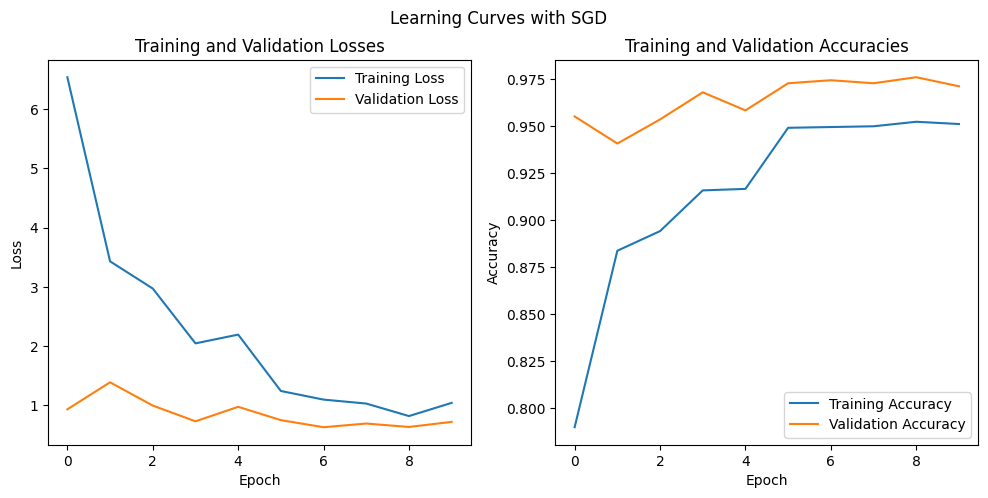

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SGD")

### Adam

Adam is different to classical stochastic gradient descent. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training. While Adam computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. Adam is suitable to train large dataset according to its paper.


Adam important parameters:
* **alpha**: Also referred to as the learning rate or step size. The proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slow learning right down during training
* **beta1**: The exponential decay rate for the first moment estimates (e.g. 0.9).
* **beta2**. The exponential decay rate for the second-moment estimates (e.g. 0.999).

Adam formula:

![](https://ambrapaliaidata.blob.core.windows.net/ai-storage/articles/image_yQDDcFh.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We also have good results in this part but SGD reached a better accuracy. Although we expected to get better results with Adam but SGD was superior: Maybe it is because of the fact that our dataset is small and Adam shows its ability more on large datasets:

Epoch: 01
	Train Loss: 0.469 | Train Acc: 83.92% | Train F1: 83.91%
	 Val. Loss: 0.195 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 02
	Train Loss: 0.248 | Train Acc: 91.50% | Train F1: 91.49%
	 Val. Loss: 0.146 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 03
	Train Loss: 0.215 | Train Acc: 92.94% | Train F1: 92.94%
	 Val. Loss: 0.142 |  Val. Acc: 95.99% | Val F1: 96.01%
Epoch: 04
	Train Loss: 0.199 | Train Acc: 93.10% | Train F1: 93.10%
	 Val. Loss: 0.119 |  Val. Acc: 96.31% | Val F1: 96.31%
Epoch: 05
	Train Loss: 0.181 | Train Acc: 93.74% | Train F1: 93.74%
	 Val. Loss: 0.103 |  Val. Acc: 97.28% | Val F1: 97.28%
Epoch: 06
	Train Loss: 0.162 | Train Acc: 94.59% | Train F1: 94.59%
	 Val. Loss: 0.102 |  Val. Acc: 96.79% | Val F1: 96.80%
Epoch: 07
	Train Loss: 0.173 | Train Acc: 94.51% | Train F1: 94.51%
	 Val. Loss: 0.106 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 08
	Train Loss: 0.150 | Train Acc: 94.91% | Train F1: 94.91%
	 Val. Loss: 0.104 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 0

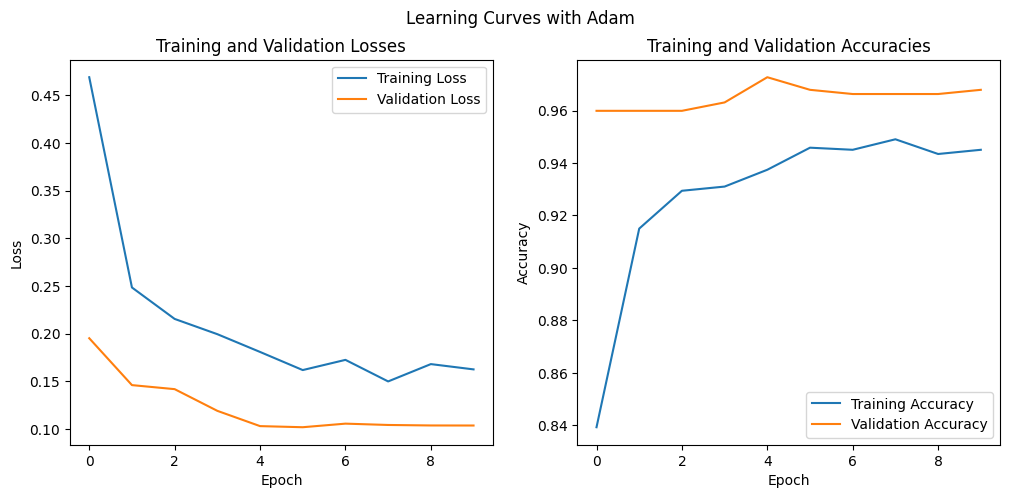

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Adam")

### AdamW

 Adam and AdamW weight decay are different. In each iteration, in Adam, the gradient is updated by the estimated parameters from the previous iteration weighted by the weight decay. On the other hand, in AdamW, the parameters are updated by the parameters from the previous iteration weighted by the weight decay.
 ![](https://i.stack.imgur.com/guHfM.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

The results are similar to Adam:

Epoch: 01
	Train Loss: 0.476 | Train Acc: 83.36% | Train F1: 83.38%
	 Val. Loss: 0.192 |  Val. Acc: 95.19% | Val F1: 95.19%
Epoch: 02
	Train Loss: 0.247 | Train Acc: 91.38% | Train F1: 91.38%
	 Val. Loss: 0.154 |  Val. Acc: 95.51% | Val F1: 95.52%
Epoch: 03
	Train Loss: 0.211 | Train Acc: 93.02% | Train F1: 93.02%
	 Val. Loss: 0.124 |  Val. Acc: 96.63% | Val F1: 96.64%
Epoch: 04
	Train Loss: 0.197 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.117 |  Val. Acc: 96.31% | Val F1: 96.33%
Epoch: 05
	Train Loss: 0.185 | Train Acc: 94.03% | Train F1: 94.03%
	 Val. Loss: 0.111 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 06
	Train Loss: 0.164 | Train Acc: 94.79% | Train F1: 94.79%
	 Val. Loss: 0.109 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 07
	Train Loss: 0.152 | Train Acc: 94.99% | Train F1: 94.99%
	 Val. Loss: 0.108 |  Val. Acc: 96.96% | Val F1: 96.96%
Epoch: 08
	Train Loss: 0.155 | Train Acc: 94.75% | Train F1: 94.75%
	 Val. Loss: 0.108 |  Val. Acc: 96.79% | Val F1: 96.80%
Epoch: 0

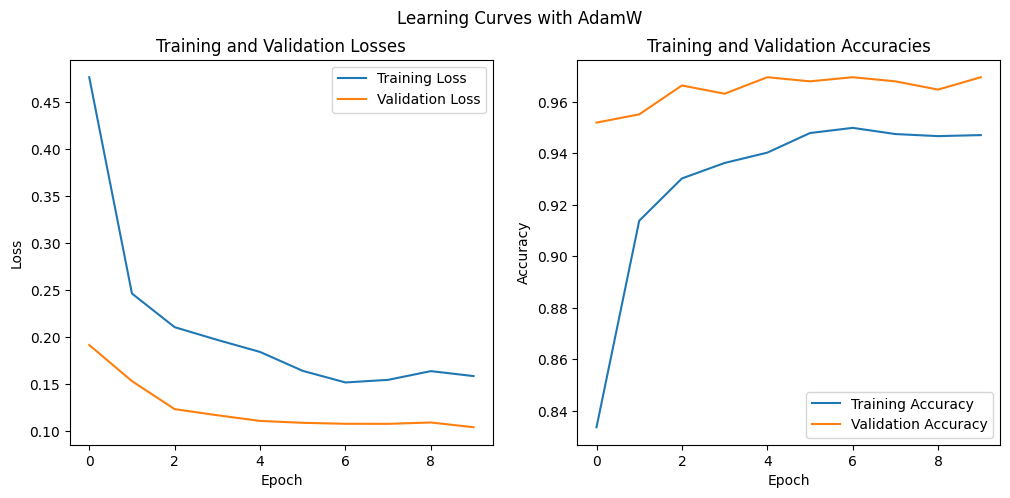

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "AdamW")

### RMSprop

RMSProp (Root Mean Squared Propagation) works by exponentially decaying the learning rate every time the squared gradient is less than a certain threshold. This helps reduce the learning rate more quickly when the gradients become small. In this way, RMSProp is able to smoothly adjust the learning rate for each of the parameters in the network, providing a better performance than regular Gradient Descent alone. The RMSprop algorithm utilizes exponentially weighted moving averages of squared gradients to update the parameters.

RMSProp Formula:
![](https://blog.paperspace.com/content/images/2018/06/momprop2-2.png)

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Same as other optimizers!

Epoch: 01
	Train Loss: 0.545 | Train Acc: 82.76% | Train F1: 82.76%
	 Val. Loss: 0.160 |  Val. Acc: 94.87% | Val F1: 94.89%
Epoch: 02
	Train Loss: 0.266 | Train Acc: 90.38% | Train F1: 90.38%
	 Val. Loss: 0.133 |  Val. Acc: 95.83% | Val F1: 95.84%
Epoch: 03
	Train Loss: 0.244 | Train Acc: 91.10% | Train F1: 91.10%
	 Val. Loss: 0.148 |  Val. Acc: 94.71% | Val F1: 94.72%
Epoch: 04
	Train Loss: 0.208 | Train Acc: 92.94% | Train F1: 92.95%
	 Val. Loss: 0.125 |  Val. Acc: 95.83% | Val F1: 95.83%
Epoch: 05
	Train Loss: 0.203 | Train Acc: 92.58% | Train F1: 92.58%
	 Val. Loss: 0.114 |  Val. Acc: 96.47% | Val F1: 96.47%
Epoch: 06
	Train Loss: 0.163 | Train Acc: 94.31% | Train F1: 94.30%
	 Val. Loss: 0.101 |  Val. Acc: 96.63% | Val F1: 96.64%
Epoch: 07
	Train Loss: 0.163 | Train Acc: 94.39% | Train F1: 94.39%
	 Val. Loss: 0.102 |  Val. Acc: 96.47% | Val F1: 96.47%
Epoch: 08
	Train Loss: 0.146 | Train Acc: 95.11% | Train F1: 95.11%
	 Val. Loss: 0.102 |  Val. Acc: 96.47% | Val F1: 96.47%
Epoch: 0

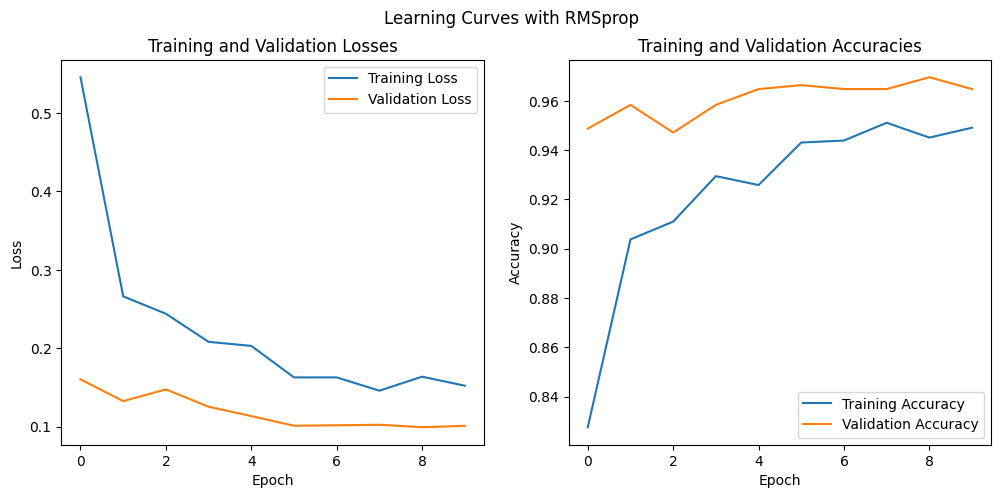

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RMSprop")

### Sharpness-Aware Minimization (SAM)

Sharpness-Aware Minimization, or SAM, is a procedure that improves model generalization by simultaneously minimizing loss value and loss sharpness. SAM functions by seeking parameters that lie in neighborhoods having uniformly low loss value (rather than parameters that only themselves have low loss value). Sharpness measures how quickly the training loss can be increased by moving from w to a nearby parameter value w + ϵ.


SAM needs two forward-backward passes to estime the "sharpness-aware" gradient so we should make sure that run two forward passes.

SAM phases:
* First pass: Compute the regular gradient and update the model parameters using the base optimizer.
* Second pass: Compute the sharpness-aware gradient and update the model parameters: $ \theta_{\text{new}} = \theta - \alpha \cdot \nabla_{\theta} L(\theta) $ where $\alpha$ is the learning rate.

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We don't see major difference with other networks:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 01
	Train Loss: 3.392 | Train Acc: 80.83% | Train F1: 80.84%
	 Val. Loss: 1.522 |  Val. Acc: 93.75% | Val F1: 93.76%
Epoch: 02
	Train Loss: 2.356 | Train Acc: 89.70% | Train F1: 89.70%
	 Val. Loss: 0.627 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 03
	Train Loss: 1.804 | Train Acc: 91.38% | Train F1: 91.38%
	 Val. Loss: 1.113 |  Val. Acc: 94.55% | Val F1: 94.49%
Epoch: 04
	Train Loss: 2.367 | Train Acc: 89.29% | Train F1: 89.28%
	 Val. Loss: 0.889 |  Val. Acc: 95.03% | Val F1: 95.06%
Epoch: 05
	Train Loss: 2.496 | Train Acc: 90.70% | Train F1: 90.70%
	 Val. Loss: 1.145 |  Val. Acc: 95.19% | Val F1: 95.21%
Epoch: 06
	Train Loss: 1.195 | Train Acc: 94.59% | Train F1: 94.59%
	 Val. Loss: 0.881 |  Val. Acc: 96.15% | Val F1: 96.15%
Epoch: 07
	Train Loss: 1.040 | Train Acc: 95.07% | Train F1: 95.07%
	 Val. Loss: 0.942 |  Val. Acc: 95.99% | Val F1: 96.01%
Epoch: 08
	Train Loss: 0.974 | Train Acc: 95.31% | Train F1: 95.31%
	 Val. Loss: 0.774 |  Val. Acc: 96.47% | Val F1: 96.47%
Epoch: 0

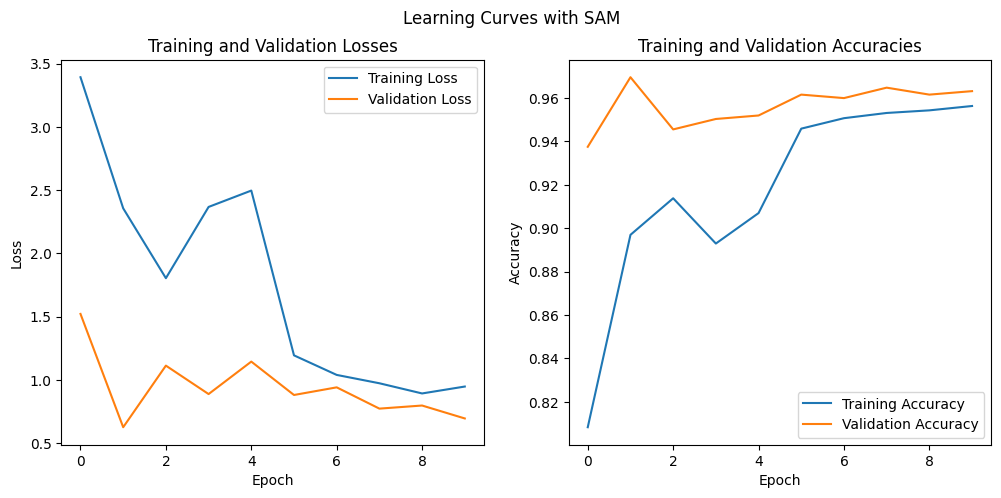

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SAM")

## MobileNet-V3

In the following parts you can see the performance of different optimizers on MobileNet. ResNet-152 had better results but there is not such a big difference between these two models. The best version of MobileNet was with RMSProp:

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Stochastic Gradient Descent (SGD)

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.433 | Train Acc: 88.45% | Train F1: 88.45%
	 Val. Loss: 0.275 |  Val. Acc: 92.63% | Val F1: 92.65%
Epoch: 02
	Train Loss: 0.523 | Train Acc: 89.78% | Train F1: 89.77%
	 Val. Loss: 0.489 |  Val. Acc: 90.06% | Val F1: 90.15%
Epoch: 03
	Train Loss: 0.457 | Train Acc: 90.86% | Train F1: 90.86%
	 Val. Loss: 0.427 |  Val. Acc: 92.63% | Val F1: 92.65%
Epoch: 04
	Train Loss: 0.519 | Train Acc: 90.54% | Train F1: 90.54%
	 Val. Loss: 0.384 |  Val. Acc: 92.15% | Val F1: 92.13%
Epoch: 05
	Train Loss: 0.486 | Train Acc: 91.26% | Train F1: 91.26%
	 Val. Loss: 0.461 |  Val. Acc: 92.63% | Val F1: 92.64%
Epoch: 06
	Train Loss: 0.399 | Train Acc: 92.62% | Train F1: 92.62%
	 Val. Loss: 0.462 |  Val. Acc: 93.11% | Val F1: 93.12%
Epoch: 07
	Train Loss: 0.346 | Train Acc: 93.42% | Train F1: 93.42%
	 Val. Loss: 0.451 |  Val. Acc: 93.43% | Val F1: 93.45%
Epoch: 08
	Train Loss: 0.301 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.442 |  Val. Acc: 93.27% | Val F1: 93.28%
Epoch: 0

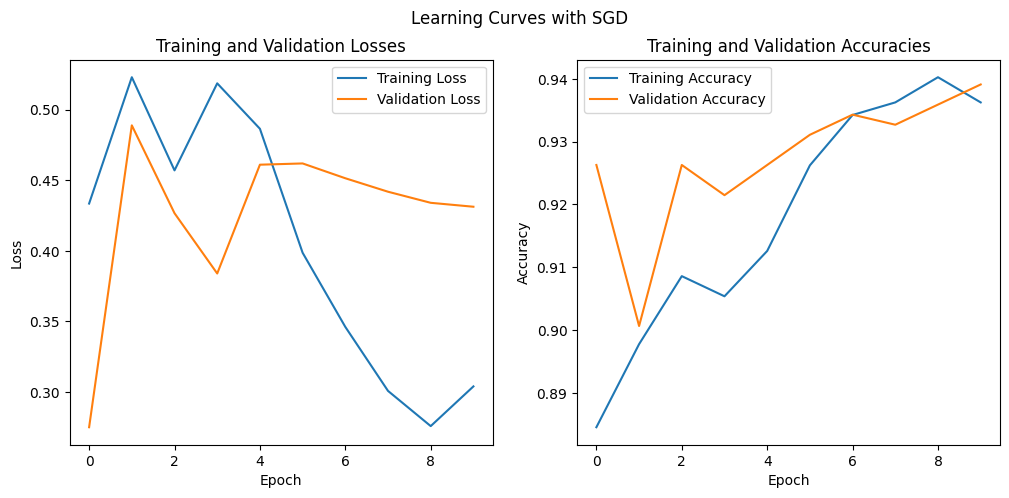

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SGD")

### Adam

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.473 | Train Acc: 83.92% | Train F1: 83.90%
	 Val. Loss: 0.217 |  Val. Acc: 93.27% | Val F1: 93.29%
Epoch: 02
	Train Loss: 0.256 | Train Acc: 91.34% | Train F1: 91.33%
	 Val. Loss: 0.191 |  Val. Acc: 93.27% | Val F1: 93.30%
Epoch: 03
	Train Loss: 0.223 | Train Acc: 92.90% | Train F1: 92.90%
	 Val. Loss: 0.183 |  Val. Acc: 93.11% | Val F1: 93.15%
Epoch: 04
	Train Loss: 0.201 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.172 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 05
	Train Loss: 0.204 | Train Acc: 93.22% | Train F1: 93.22%
	 Val. Loss: 0.165 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 06
	Train Loss: 0.191 | Train Acc: 93.14% | Train F1: 93.14%
	 Val. Loss: 0.165 |  Val. Acc: 93.75% | Val F1: 93.79%
Epoch: 07
	Train Loss: 0.177 | Train Acc: 94.03% | Train F1: 94.02%
	 Val. Loss: 0.162 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 08
	Train Loss: 0.188 | Train Acc: 93.58% | Train F1: 93.58%
	 Val. Loss: 0.160 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 0

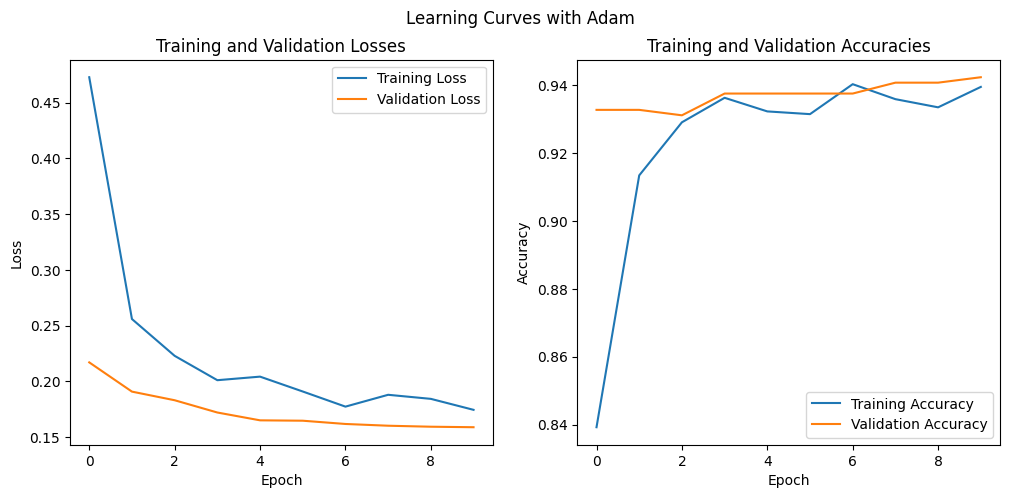

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Adam")

### AdamW

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.496 | Train Acc: 82.12% | Train F1: 82.11%
	 Val. Loss: 0.221 |  Val. Acc: 94.23% | Val F1: 94.27%
Epoch: 02
	Train Loss: 0.272 | Train Acc: 91.46% | Train F1: 91.46%
	 Val. Loss: 0.189 |  Val. Acc: 93.91% | Val F1: 93.95%
Epoch: 03
	Train Loss: 0.226 | Train Acc: 92.02% | Train F1: 92.02%
	 Val. Loss: 0.170 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 04
	Train Loss: 0.214 | Train Acc: 92.90% | Train F1: 92.91%
	 Val. Loss: 0.160 |  Val. Acc: 94.55% | Val F1: 94.57%
Epoch: 05
	Train Loss: 0.194 | Train Acc: 93.83% | Train F1: 93.82%
	 Val. Loss: 0.161 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 06
	Train Loss: 0.183 | Train Acc: 93.62% | Train F1: 93.63%
	 Val. Loss: 0.158 |  Val. Acc: 94.23% | Val F1: 94.25%
Epoch: 07
	Train Loss: 0.179 | Train Acc: 93.66% | Train F1: 93.66%
	 Val. Loss: 0.156 |  Val. Acc: 94.39% | Val F1: 94.42%
Epoch: 08
	Train Loss: 0.190 | Train Acc: 92.98% | Train F1: 92.98%
	 Val. Loss: 0.153 |  Val. Acc: 94.55% | Val F1: 94.58%
Epoch: 0

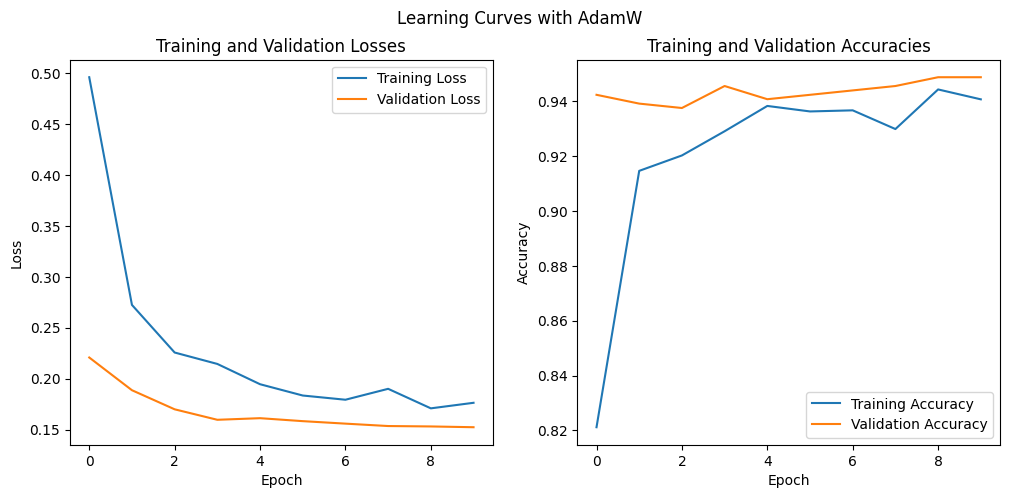

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "AdamW")

### RMSprop

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.315 | Train Acc: 89.09% | Train F1: 89.10%
	 Val. Loss: 0.165 |  Val. Acc: 94.71% | Val F1: 94.76%
Epoch: 02
	Train Loss: 0.215 | Train Acc: 93.02% | Train F1: 93.02%
	 Val. Loss: 0.162 |  Val. Acc: 93.91% | Val F1: 93.95%
Epoch: 03
	Train Loss: 0.196 | Train Acc: 93.30% | Train F1: 93.30%
	 Val. Loss: 0.164 |  Val. Acc: 93.43% | Val F1: 93.48%
Epoch: 04
	Train Loss: 0.193 | Train Acc: 93.42% | Train F1: 93.42%
	 Val. Loss: 0.165 |  Val. Acc: 93.91% | Val F1: 93.95%
Epoch: 05
	Train Loss: 0.172 | Train Acc: 94.19% | Train F1: 94.19%
	 Val. Loss: 0.161 |  Val. Acc: 94.07% | Val F1: 94.09%
Epoch: 06
	Train Loss: 0.165 | Train Acc: 94.35% | Train F1: 94.35%
	 Val. Loss: 0.160 |  Val. Acc: 94.39% | Val F1: 94.41%
Epoch: 07
	Train Loss: 0.171 | Train Acc: 93.83% | Train F1: 93.82%
	 Val. Loss: 0.157 |  Val. Acc: 95.03% | Val F1: 95.04%
Epoch: 08
	Train Loss: 0.161 | Train Acc: 94.31% | Train F1: 94.30%
	 Val. Loss: 0.157 |  Val. Acc: 94.87% | Val F1: 94.88%
Epoch: 0

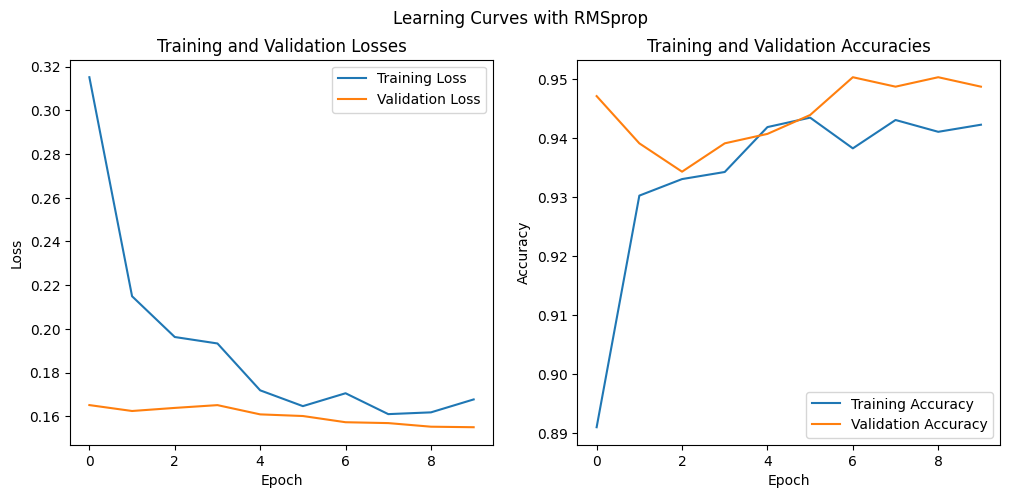

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RMSprop")

### Sharpness-Aware Minimization (SAM)

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 01
	Train Loss: 0.547 | Train Acc: 86.49% | Train F1: 86.49%
	 Val. Loss: 0.524 |  Val. Acc: 91.03% | Val F1: 91.07%
Epoch: 02
	Train Loss: 0.546 | Train Acc: 90.02% | Train F1: 90.01%
	 Val. Loss: 0.477 |  Val. Acc: 91.03% | Val F1: 91.08%
Epoch: 03
	Train Loss: 0.443 | Train Acc: 91.10% | Train F1: 91.10%
	 Val. Loss: 0.555 |  Val. Acc: 91.67% | Val F1: 91.67%
Epoch: 04
	Train Loss: 0.491 | Train Acc: 91.86% | Train F1: 91.85%
	 Val. Loss: 0.562 |  Val. Acc: 92.31% | Val F1: 92.32%
Epoch: 05
	Train Loss: 0.486 | Train Acc: 91.74% | Train F1: 91.74%
	 Val. Loss: 0.594 |  Val. Acc: 92.47% | Val F1: 92.47%
Epoch: 06
	Train Loss: 0.395 | Train Acc: 92.74% | Train F1: 92.75%
	 Val. Loss: 0.561 |  Val. Acc: 92.79% | Val F1: 92.79%
Epoch: 07
	Train Loss: 0.344 | Train Acc: 93.34% | Train F1: 93.35%
	 Val. Loss: 0.552 |  Val. Acc: 93.27% | Val F1: 93.27%
Epoch: 08
	Train Loss: 0.385 | Train Acc: 92.98% | Train F1: 92.99%
	 Val. Loss: 0.542 |  Val. Acc: 93.59% | Val F1: 93.60%
Epoch: 0

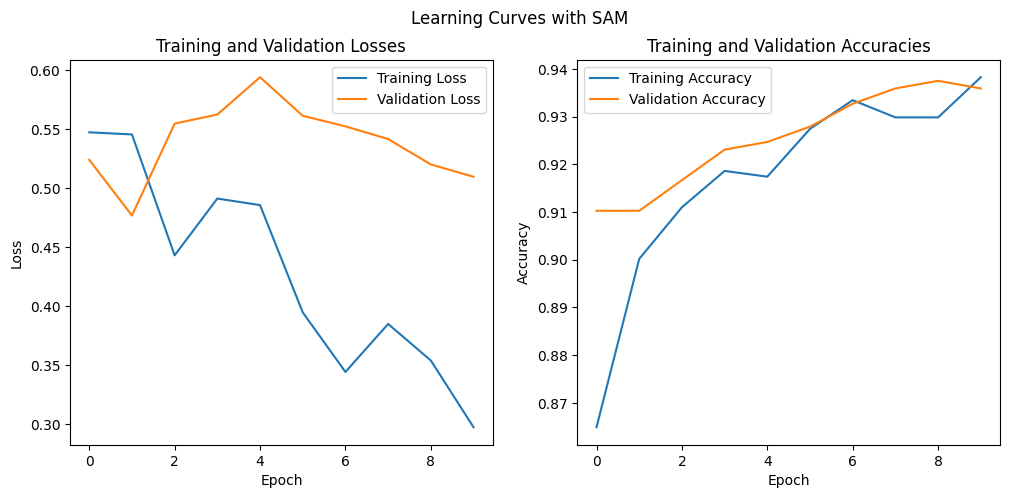

In [ ]:
# Train the model
num_epochs = 5

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SAM")

## Custom CNN

Finally we have our custom CNN!

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Stochastic Gradient Descent (SGD)

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

It seems that SGD is not a good optimizer for this network. The performance is not so good:

Epoch: 01
	Train Loss: 0.919 | Train Acc: 61.35% | Train F1: 61.14%
	 Val. Loss: 0.916 |  Val. Acc: 63.14% | Val F1: 61.33%
Epoch: 02
	Train Loss: 0.870 | Train Acc: 67.04% | Train F1: 67.05%
	 Val. Loss: 0.841 |  Val. Acc: 70.35% | Val F1: 69.91%
Epoch: 03
	Train Loss: 0.860 | Train Acc: 68.32% | Train F1: 68.21%
	 Val. Loss: 0.809 |  Val. Acc: 73.88% | Val F1: 74.02%
Epoch: 04
	Train Loss: 0.875 | Train Acc: 67.04% | Train F1: 67.22%
	 Val. Loss: 0.936 |  Val. Acc: 61.38% | Val F1: 55.54%
Epoch: 05
	Train Loss: 0.838 | Train Acc: 70.85% | Train F1: 71.00%
	 Val. Loss: 0.884 |  Val. Acc: 66.19% | Val F1: 65.78%
Epoch: 06
	Train Loss: 0.826 | Train Acc: 71.57% | Train F1: 71.54%
	 Val. Loss: 0.788 |  Val. Acc: 75.32% | Val F1: 75.34%
Epoch: 07
	Train Loss: 0.784 | Train Acc: 76.18% | Train F1: 76.27%
	 Val. Loss: 0.774 |  Val. Acc: 77.08% | Val F1: 77.14%
Epoch: 08
	Train Loss: 0.795 | Train Acc: 74.90% | Train F1: 74.99%
	 Val. Loss: 0.778 |  Val. Acc: 77.56% | Val F1: 77.74%
Epoch: 0

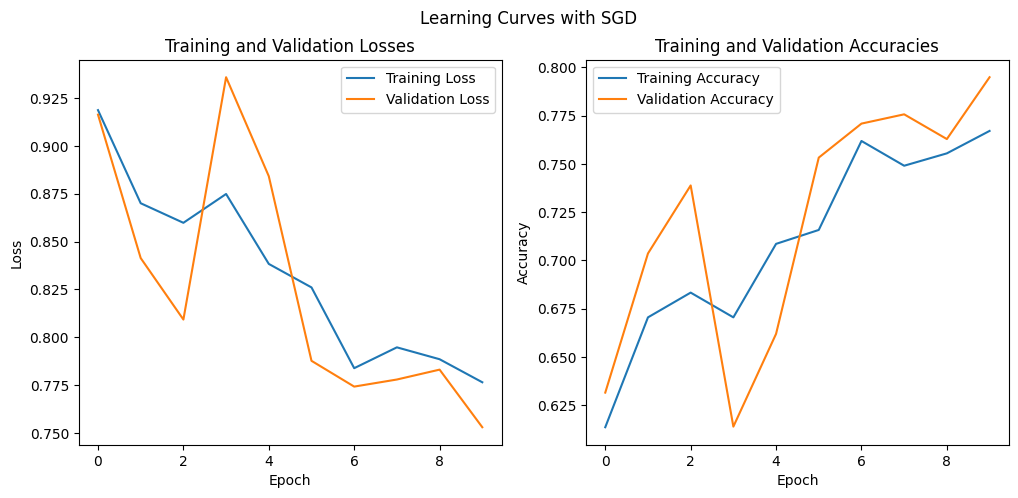

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SGD")

### Adam

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Adam seems to be a more suitable optimizer for this model. We see improvements in accuracy compared with the last case:

Epoch: 01
	Train Loss: 0.892 | Train Acc: 63.95% | Train F1: 63.56%
	 Val. Loss: 0.817 |  Val. Acc: 72.12% | Val F1: 71.73%
Epoch: 02
	Train Loss: 0.827 | Train Acc: 71.65% | Train F1: 71.69%
	 Val. Loss: 0.816 |  Val. Acc: 72.44% | Val F1: 70.75%
Epoch: 03
	Train Loss: 0.789 | Train Acc: 75.54% | Train F1: 75.63%
	 Val. Loss: 0.965 |  Val. Acc: 58.33% | Val F1: 48.83%
Epoch: 04
	Train Loss: 0.777 | Train Acc: 77.23% | Train F1: 77.32%
	 Val. Loss: 0.835 |  Val. Acc: 71.63% | Val F1: 68.99%
Epoch: 05
	Train Loss: 0.782 | Train Acc: 76.06% | Train F1: 76.15%
	 Val. Loss: 0.748 |  Val. Acc: 80.13% | Val F1: 80.54%
Epoch: 06
	Train Loss: 0.731 | Train Acc: 81.84% | Train F1: 81.95%
	 Val. Loss: 0.720 |  Val. Acc: 82.53% | Val F1: 82.70%
Epoch: 07
	Train Loss: 0.720 | Train Acc: 82.64% | Train F1: 82.72%
	 Val. Loss: 0.694 |  Val. Acc: 85.74% | Val F1: 85.88%
Epoch: 08
	Train Loss: 0.716 | Train Acc: 83.32% | Train F1: 83.38%
	 Val. Loss: 0.727 |  Val. Acc: 82.05% | Val F1: 82.13%
Epoch: 0

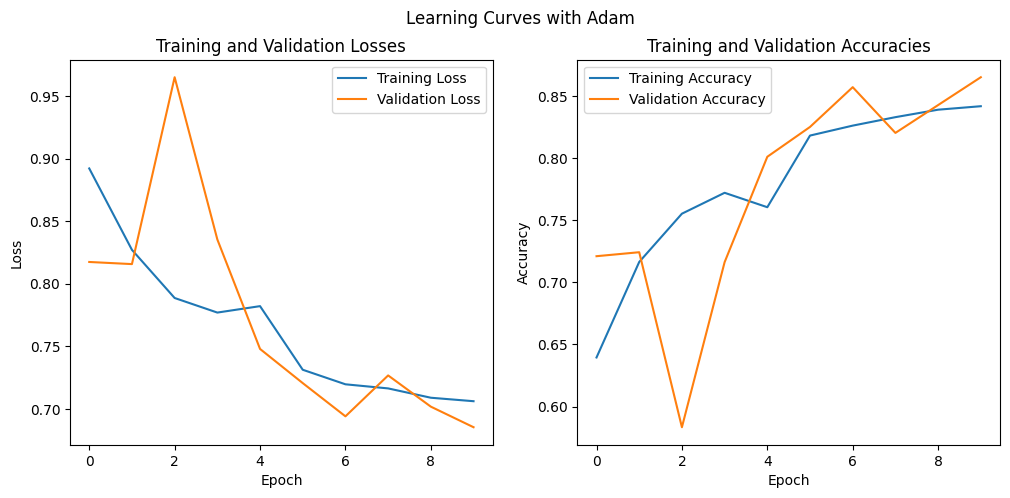

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "Adam")

### AdamW

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

To the this point, AdamW is the best choice for our CNN Model based on the results:

Epoch: 01
	Train Loss: 0.890 | Train Acc: 64.80% | Train F1: 64.68%
	 Val. Loss: 0.912 |  Val. Acc: 63.78% | Val F1: 61.83%
Epoch: 02
	Train Loss: 0.803 | Train Acc: 74.42% | Train F1: 74.53%
	 Val. Loss: 0.986 |  Val. Acc: 54.49% | Val F1: 45.18%
Epoch: 03
	Train Loss: 0.778 | Train Acc: 77.31% | Train F1: 77.33%
	 Val. Loss: 0.993 |  Val. Acc: 55.61% | Val F1: 48.21%
Epoch: 04
	Train Loss: 0.763 | Train Acc: 78.35% | Train F1: 78.30%
	 Val. Loss: 0.748 |  Val. Acc: 79.81% | Val F1: 79.96%
Epoch: 05
	Train Loss: 0.742 | Train Acc: 80.91% | Train F1: 80.99%
	 Val. Loss: 0.879 |  Val. Acc: 66.67% | Val F1: 63.43%
Epoch: 06
	Train Loss: 0.714 | Train Acc: 84.24% | Train F1: 84.32%
	 Val. Loss: 0.682 |  Val. Acc: 86.70% | Val F1: 86.80%
Epoch: 07
	Train Loss: 0.704 | Train Acc: 84.28% | Train F1: 84.35%
	 Val. Loss: 0.688 |  Val. Acc: 85.90% | Val F1: 86.02%
Epoch: 08
	Train Loss: 0.695 | Train Acc: 85.53% | Train F1: 85.57%
	 Val. Loss: 0.661 |  Val. Acc: 90.38% | Val F1: 90.42%
Epoch: 0

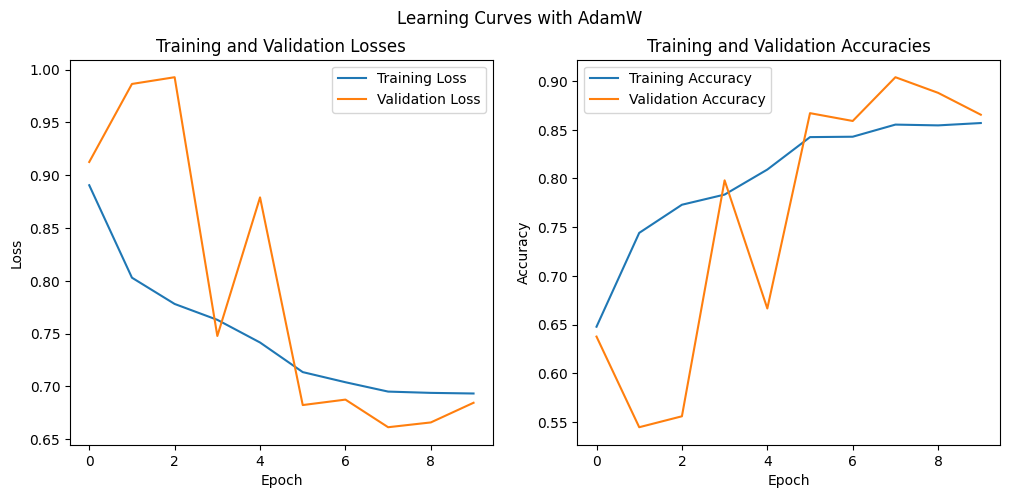

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "AdamW")

### RMSprop

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Although RMSProp has harsh ups and downs at the start of training but it showed an stable improvement after some time and also good performance:

Epoch: 01
	Train Loss: 0.914 | Train Acc: 61.71% | Train F1: 61.68%
	 Val. Loss: 0.829 |  Val. Acc: 71.47% | Val F1: 69.69%
Epoch: 02
	Train Loss: 0.849 | Train Acc: 69.01% | Train F1: 69.07%
	 Val. Loss: 1.111 |  Val. Acc: 41.19% | Val F1: 32.35%
Epoch: 03
	Train Loss: 0.808 | Train Acc: 73.62% | Train F1: 73.77%
	 Val. Loss: 0.897 |  Val. Acc: 63.62% | Val F1: 62.27%
Epoch: 04
	Train Loss: 0.799 | Train Acc: 74.30% | Train F1: 74.39%
	 Val. Loss: 1.058 |  Val. Acc: 49.52% | Val F1: 39.94%
Epoch: 05
	Train Loss: 0.764 | Train Acc: 78.23% | Train F1: 78.33%
	 Val. Loss: 0.947 |  Val. Acc: 58.97% | Val F1: 55.95%
Epoch: 06
	Train Loss: 0.720 | Train Acc: 83.08% | Train F1: 83.13%
	 Val. Loss: 0.689 |  Val. Acc: 86.86% | Val F1: 86.77%
Epoch: 07
	Train Loss: 0.708 | Train Acc: 84.04% | Train F1: 84.10%
	 Val. Loss: 0.678 |  Val. Acc: 87.34% | Val F1: 87.43%
Epoch: 08
	Train Loss: 0.702 | Train Acc: 85.00% | Train F1: 85.04%
	 Val. Loss: 0.670 |  Val. Acc: 88.46% | Val F1: 88.50%
Epoch: 0

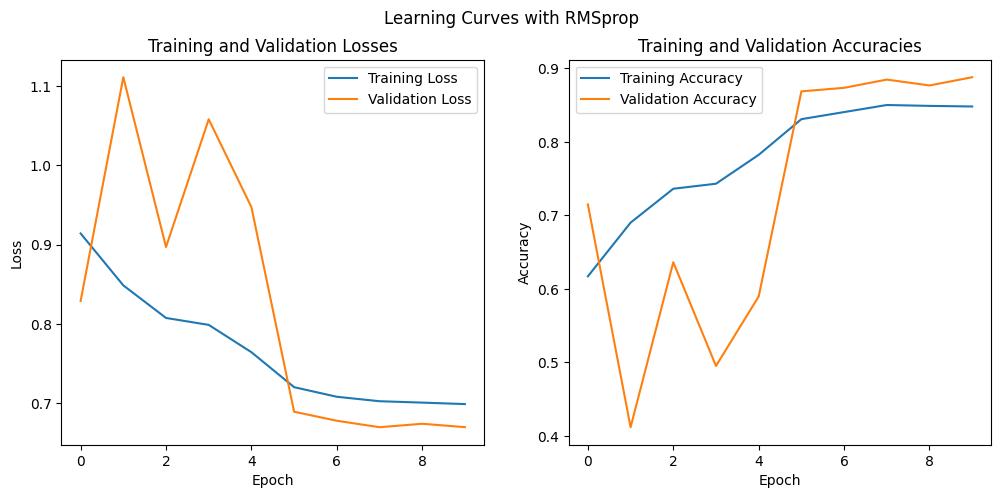

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "RMSprop")

### Sharpness-Aware Minimization (SAM)

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

SAM does not show good results on our network and it is the worst optimizer! SAM help to improve the model generality but maybe our network is not too huge to need this:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 01
	Train Loss: 1.004 | Train Acc: 53.65% | Train F1: 47.11%
	 Val. Loss: 0.925 |  Val. Acc: 62.34% | Val F1: 50.35%
Epoch: 02
	Train Loss: 0.968 | Train Acc: 57.42% | Train F1: 46.37%
	 Val. Loss: 0.932 |  Val. Acc: 61.06% | Val F1: 49.15%
Epoch: 03
	Train Loss: 0.953 | Train Acc: 58.86% | Train F1: 47.34%
	 Val. Loss: 0.924 |  Val. Acc: 62.34% | Val F1: 51.34%
Epoch: 04
	Train Loss: 0.941 | Train Acc: 60.14% | Train F1: 48.33%
	 Val. Loss: 0.922 |  Val. Acc: 62.82% | Val F1: 51.69%
Epoch: 05
	Train Loss: 0.934 | Train Acc: 60.99% | Train F1: 48.94%
	 Val. Loss: 0.915 |  Val. Acc: 62.82% | Val F1: 50.67%
Epoch: 06
	Train Loss: 0.924 | Train Acc: 61.87% | Train F1: 49.65%
	 Val. Loss: 0.900 |  Val. Acc: 64.74% | Val F1: 52.64%
Epoch: 07
	Train Loss: 0.925 | Train Acc: 61.79% | Train F1: 49.58%
	 Val. Loss: 0.897 |  Val. Acc: 64.74% | Val F1: 52.30%
Epoch: 08
	Train Loss: 0.915 | Train Acc: 62.63% | Train F1: 50.22%
	 Val. Loss: 0.898 |  Val. Acc: 64.74% | Val F1: 52.18%
Epoch: 0

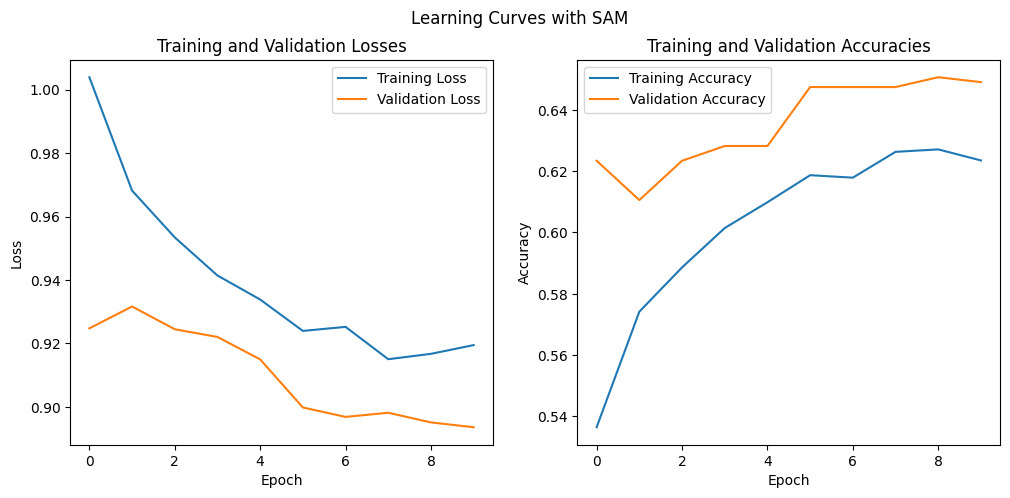

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_optimizer(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "SAM")

# Learning Rate Schedular

Finally we have LR schedulers!

In [ ]:
def train_model_with_schedular(model, train_loader, val_loader, criterion, optimizer, scheduler, transform=None, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    opt_name = optimizer.__class__.__name__

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train = []
        all_predictions_train = []

        for inputs, labels  in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            if transform == 'mixup':
                mixup_inputs, mixup_labels = mixup_data(inputs, labels, num_classes=3)
                outputs = model(mixup_inputs)
                loss = criterion(outputs, mixup_labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            if opt_name == 'SAM':
                # SAM needs two steps
                # first forward-backward pass
                optimizer.first_step(zero_grad=True)

                # second forward-backward pass
                criterion(model(inputs), labels).backward()  # make sure to do a full forward pass
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            all_labels_train.extend(labels.cpu().numpy())
            all_predictions_train.extend(predicted_train.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        epoch_accuracy_train = correct_train / total_train
        train_accuracies.append(epoch_accuracy_train)

        # Calculate F1 score
        f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_loss_val = 0.0
        all_labels_val = []
        all_predictions_val = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs_val = model(inputs)
                loss_val = criterion(outputs_val, labels)
                running_loss_val += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                all_labels_val.extend(labels.cpu().numpy())
                all_predictions_val.extend(predicted_val.cpu().numpy())

        epoch_loss_val = running_loss_val / len(val_loader)
        val_losses.append(epoch_loss_val)
        epoch_accuracy_val = correct_val / total_val
        val_accuracies.append(epoch_accuracy_val)

        # Calculate F1 score
        f1_val = f1_score(all_labels_val, all_predictions_val, average='weighted')

        # Update learning rate
        scheduler.step()

        # Print and store results for analysis
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {epoch_loss:.3f} | Train Acc: {epoch_accuracy_train*100:.2f}% | Train F1: {f1_train*100:.2f}%')
        print(f'\t Val. Loss: {epoch_loss_val:.3f} |  Val. Acc: {epoch_accuracy_val*100:.2f}% | Val F1: {f1_val*100:.2f}%')


    # Save the model weights after training
    torch.save(model.state_dict(), f'{model_save_path}/{model._get_name()}_{scheduler.__class__.__name__}.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

We use ColorJitter as base transform and Adam as optimizer:

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

base_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

transform = transforms.Compose([
        color_jitter,
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [ ]:
train_dataset = CustomDataset(img_path, train_df, 'Nature_label', transform=transform)
val_dataset = CustomDataset(img_path, val_df, 'Nature_label', transform=base_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## ResNet-152

### Expotential LR

It decays the learning rate of each parameter group by gamma every epoch.

$\text{LR}(t) = LR_0 \cdot \gamma^t $

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

promising results!

Epoch: 01
	Train Loss: 0.499 | Train Acc: 81.92% | Train F1: 81.92%
	 Val. Loss: 0.207 |  Val. Acc: 93.27% | Val F1: 93.32%
Epoch: 02
	Train Loss: 0.277 | Train Acc: 90.58% | Train F1: 90.57%
	 Val. Loss: 0.210 |  Val. Acc: 93.43% | Val F1: 93.50%
Epoch: 03
	Train Loss: 0.250 | Train Acc: 91.38% | Train F1: 91.38%
	 Val. Loss: 0.147 |  Val. Acc: 95.19% | Val F1: 95.20%
Epoch: 04
	Train Loss: 0.210 | Train Acc: 92.54% | Train F1: 92.55%
	 Val. Loss: 0.131 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 05
	Train Loss: 0.183 | Train Acc: 93.95% | Train F1: 93.94%
	 Val. Loss: 0.140 |  Val. Acc: 95.99% | Val F1: 95.98%
Epoch: 06
	Train Loss: 0.193 | Train Acc: 93.06% | Train F1: 93.06%
	 Val. Loss: 0.112 |  Val. Acc: 96.31% | Val F1: 96.31%
Epoch: 07
	Train Loss: 0.174 | Train Acc: 93.95% | Train F1: 93.95%
	 Val. Loss: 0.103 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 08
	Train Loss: 0.169 | Train Acc: 94.31% | Train F1: 94.31%
	 Val. Loss: 0.112 |  Val. Acc: 96.63% | Val F1: 96.63%
Epoch: 0

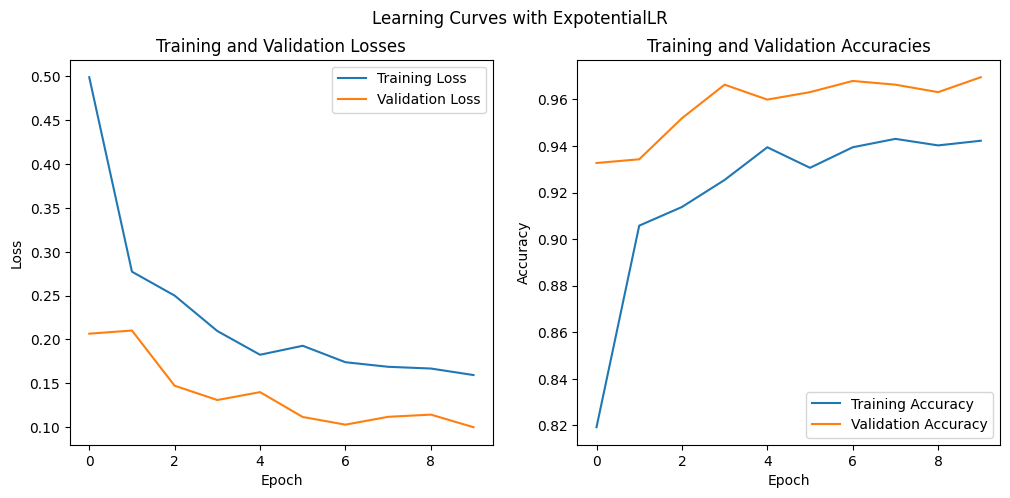

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ExpotentialLR")

### Linear LR

It decays the learning rate of each parameter group by linearly changing small multiplicative factor until the number of epoch reaches a pre-defined milestone: total_iters.

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)

Again good results!

Epoch: 01
	Train Loss: 0.469 | Train Acc: 83.92% | Train F1: 83.91%
	 Val. Loss: 0.195 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 02
	Train Loss: 0.249 | Train Acc: 91.50% | Train F1: 91.49%
	 Val. Loss: 0.149 |  Val. Acc: 95.51% | Val F1: 95.53%
Epoch: 03
	Train Loss: 0.218 | Train Acc: 92.78% | Train F1: 92.78%
	 Val. Loss: 0.139 |  Val. Acc: 95.83% | Val F1: 95.85%
Epoch: 04
	Train Loss: 0.199 | Train Acc: 93.46% | Train F1: 93.46%
	 Val. Loss: 0.118 |  Val. Acc: 96.47% | Val F1: 96.48%
Epoch: 05
	Train Loss: 0.179 | Train Acc: 93.95% | Train F1: 93.94%
	 Val. Loss: 0.108 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 06
	Train Loss: 0.179 | Train Acc: 93.62% | Train F1: 93.63%
	 Val. Loss: 0.127 |  Val. Acc: 96.15% | Val F1: 96.15%
Epoch: 07
	Train Loss: 0.180 | Train Acc: 93.74% | Train F1: 93.74%
	 Val. Loss: 0.111 |  Val. Acc: 96.96% | Val F1: 96.96%
Epoch: 08
	Train Loss: 0.157 | Train Acc: 94.59% | Train F1: 94.59%
	 Val. Loss: 0.112 |  Val. Acc: 95.67% | Val F1: 95.69%
Epoch: 0

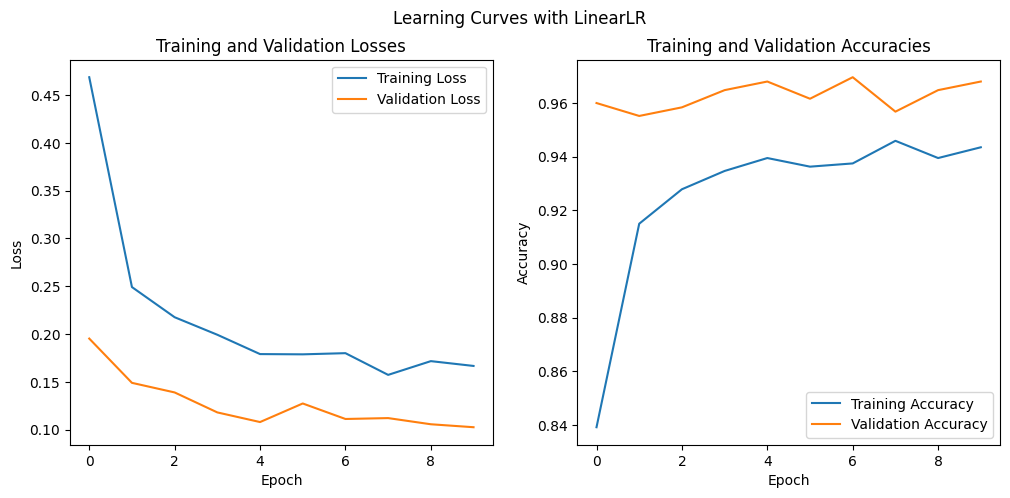

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "LinearLR")

### Cyclic LR

CLR aims to find an optimal learning rate by cycling it between two boundaries for learning rate. It sets the learning rate of each parameter group according to cyclical learning rate policy (CLR). The distance between the two boundaries can be scaled on a per-iteration or per-cycle basis.

In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2000, cycle_momentum=False)

Similar results!

Epoch: 01
	Train Loss: 0.476 | Train Acc: 83.36% | Train F1: 83.38%
	 Val. Loss: 0.192 |  Val. Acc: 95.19% | Val F1: 95.19%
Epoch: 02
	Train Loss: 0.247 | Train Acc: 91.38% | Train F1: 91.38%
	 Val. Loss: 0.154 |  Val. Acc: 95.67% | Val F1: 95.68%
Epoch: 03
	Train Loss: 0.211 | Train Acc: 92.94% | Train F1: 92.94%
	 Val. Loss: 0.123 |  Val. Acc: 96.63% | Val F1: 96.64%
Epoch: 04
	Train Loss: 0.198 | Train Acc: 93.54% | Train F1: 93.54%
	 Val. Loss: 0.117 |  Val. Acc: 96.31% | Val F1: 96.33%
Epoch: 05
	Train Loss: 0.184 | Train Acc: 94.07% | Train F1: 94.07%
	 Val. Loss: 0.111 |  Val. Acc: 96.96% | Val F1: 96.95%
Epoch: 06
	Train Loss: 0.191 | Train Acc: 93.54% | Train F1: 93.54%
	 Val. Loss: 0.145 |  Val. Acc: 95.03% | Val F1: 95.00%
Epoch: 07
	Train Loss: 0.153 | Train Acc: 94.63% | Train F1: 94.63%
	 Val. Loss: 0.107 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 08
	Train Loss: 0.161 | Train Acc: 94.51% | Train F1: 94.51%
	 Val. Loss: 0.120 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 0

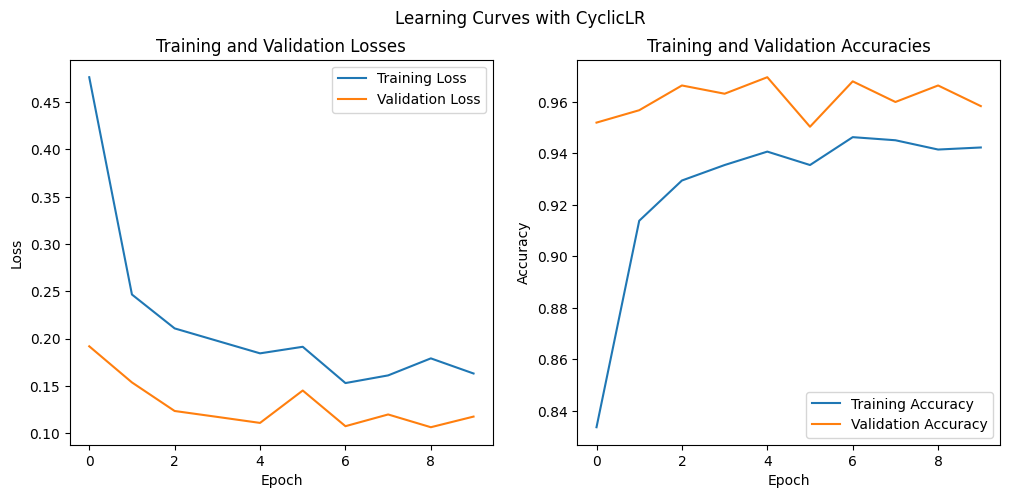

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "CyclicLR")

### Step LR

The StepLR scheduler decreases the learning rate of each parameter group by a fixed factor (often denoted as gamma) every specified number of epochs (referred to as the step size):



In [ ]:
# Instantiate the model
model = CustomResNet152Frozen(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We reached the best results with StepLR on ResNet:

Epoch: 01
	Train Loss: 0.430 | Train Acc: 85.16% | Train F1: 85.17%
	 Val. Loss: 0.189 |  Val. Acc: 93.27% | Val F1: 93.32%
Epoch: 02
	Train Loss: 0.265 | Train Acc: 90.62% | Train F1: 90.61%
	 Val. Loss: 0.145 |  Val. Acc: 96.31% | Val F1: 96.31%
Epoch: 03
	Train Loss: 0.239 | Train Acc: 91.70% | Train F1: 91.70%
	 Val. Loss: 0.123 |  Val. Acc: 95.99% | Val F1: 96.00%
Epoch: 04
	Train Loss: 0.188 | Train Acc: 93.79% | Train F1: 93.79%
	 Val. Loss: 0.133 |  Val. Acc: 95.03% | Val F1: 95.06%
Epoch: 05
	Train Loss: 0.200 | Train Acc: 93.26% | Train F1: 93.26%
	 Val. Loss: 0.110 |  Val. Acc: 96.63% | Val F1: 96.65%
Epoch: 06
	Train Loss: 0.167 | Train Acc: 94.27% | Train F1: 94.27%
	 Val. Loss: 0.103 |  Val. Acc: 96.63% | Val F1: 96.64%
Epoch: 07
	Train Loss: 0.163 | Train Acc: 94.55% | Train F1: 94.55%
	 Val. Loss: 0.104 |  Val. Acc: 96.63% | Val F1: 96.64%
Epoch: 08
	Train Loss: 0.150 | Train Acc: 95.23% | Train F1: 95.23%
	 Val. Loss: 0.103 |  Val. Acc: 96.79% | Val F1: 96.79%
Epoch: 0

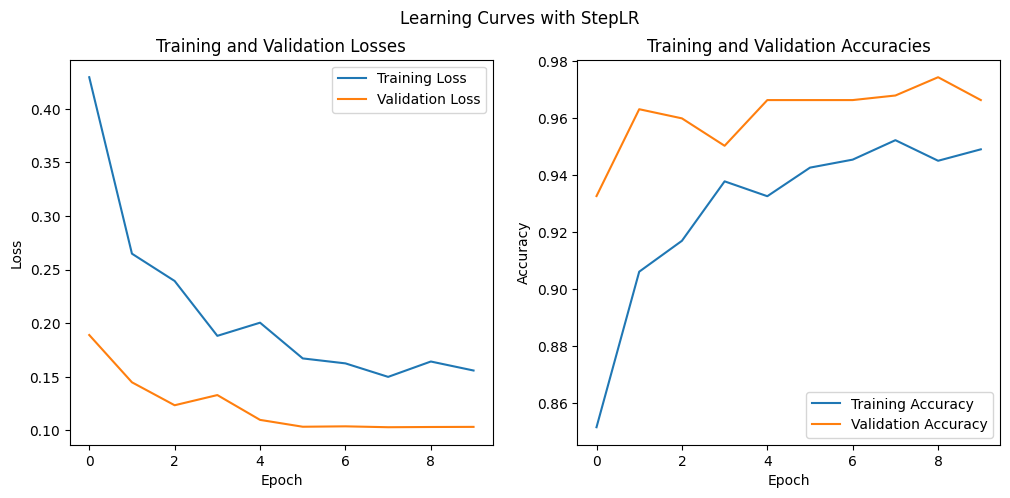

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "StepLR")

## MobileNet-V3

Based on the results there is not such a big difference between different schedulers:

### Expotential LR

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

Epoch: 01
	Train Loss: 0.465 | Train Acc: 85.16% | Train F1: 85.17%
	 Val. Loss: 0.211 |  Val. Acc: 94.07% | Val F1: 94.11%
Epoch: 02
	Train Loss: 0.265 | Train Acc: 92.06% | Train F1: 92.06%
	 Val. Loss: 0.183 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 03
	Train Loss: 0.230 | Train Acc: 92.14% | Train F1: 92.14%
	 Val. Loss: 0.170 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 04
	Train Loss: 0.213 | Train Acc: 92.98% | Train F1: 92.98%
	 Val. Loss: 0.166 |  Val. Acc: 93.91% | Val F1: 93.93%
Epoch: 05
	Train Loss: 0.181 | Train Acc: 93.54% | Train F1: 93.54%
	 Val. Loss: 0.163 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 06
	Train Loss: 0.183 | Train Acc: 93.54% | Train F1: 93.55%
	 Val. Loss: 0.165 |  Val. Acc: 94.23% | Val F1: 94.26%
Epoch: 07
	Train Loss: 0.177 | Train Acc: 93.74% | Train F1: 93.75%
	 Val. Loss: 0.160 |  Val. Acc: 94.87% | Val F1: 94.89%
Epoch: 08
	Train Loss: 0.179 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.159 |  Val. Acc: 95.03% | Val F1: 95.05%
Epoch: 0

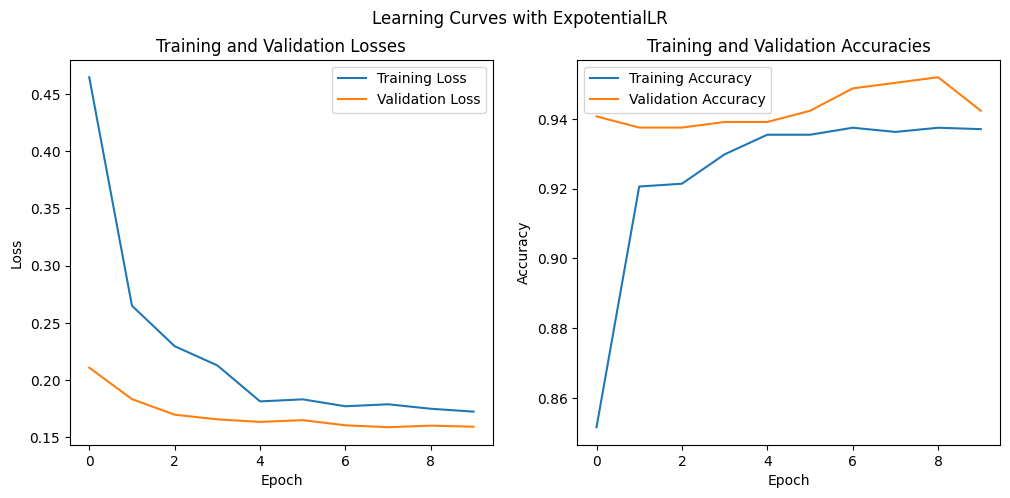

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ExpotentialLR")

### Linear LR

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)

Epoch: 01
	Train Loss: 0.469 | Train Acc: 85.49% | Train F1: 85.49%
	 Val. Loss: 0.216 |  Val. Acc: 93.91% | Val F1: 93.95%
Epoch: 02
	Train Loss: 0.260 | Train Acc: 91.78% | Train F1: 91.78%
	 Val. Loss: 0.186 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 03
	Train Loss: 0.230 | Train Acc: 92.14% | Train F1: 92.14%
	 Val. Loss: 0.168 |  Val. Acc: 93.91% | Val F1: 93.93%
Epoch: 04
	Train Loss: 0.209 | Train Acc: 92.30% | Train F1: 92.30%
	 Val. Loss: 0.158 |  Val. Acc: 94.07% | Val F1: 94.08%
Epoch: 05
	Train Loss: 0.195 | Train Acc: 93.34% | Train F1: 93.34%
	 Val. Loss: 0.158 |  Val. Acc: 93.91% | Val F1: 93.92%
Epoch: 06
	Train Loss: 0.186 | Train Acc: 93.42% | Train F1: 93.43%
	 Val. Loss: 0.156 |  Val. Acc: 93.91% | Val F1: 93.93%
Epoch: 07
	Train Loss: 0.187 | Train Acc: 93.14% | Train F1: 93.14%
	 Val. Loss: 0.155 |  Val. Acc: 94.23% | Val F1: 94.24%
Epoch: 08
	Train Loss: 0.168 | Train Acc: 94.03% | Train F1: 94.03%
	 Val. Loss: 0.154 |  Val. Acc: 94.23% | Val F1: 94.24%
Epoch: 0

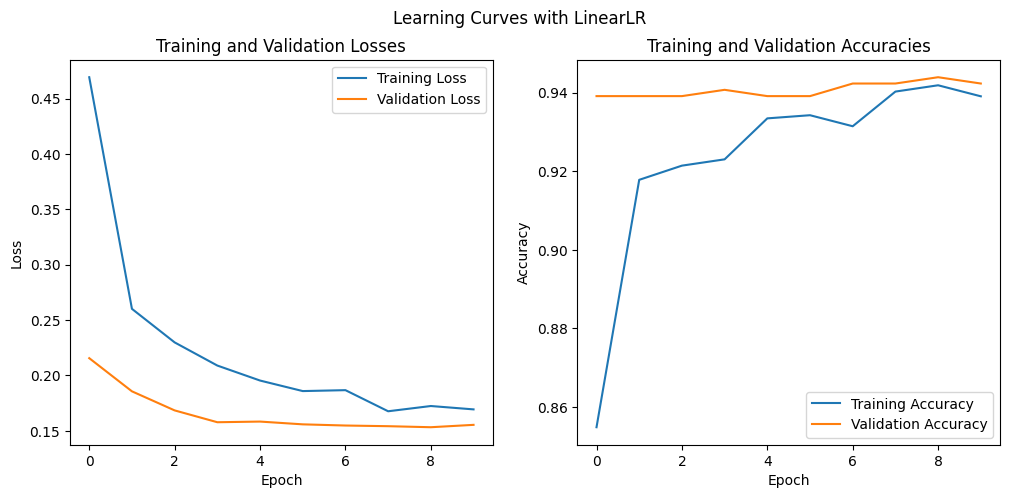

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "LinearLR")

### Cyclic LR

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2000, cycle_momentum=False)

Epoch: 01
	Train Loss: 0.482 | Train Acc: 83.24% | Train F1: 83.24%
	 Val. Loss: 0.214 |  Val. Acc: 93.75% | Val F1: 93.79%
Epoch: 02
	Train Loss: 0.266 | Train Acc: 90.86% | Train F1: 90.86%
	 Val. Loss: 0.183 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 03
	Train Loss: 0.235 | Train Acc: 92.30% | Train F1: 92.30%
	 Val. Loss: 0.177 |  Val. Acc: 93.43% | Val F1: 93.46%
Epoch: 04
	Train Loss: 0.214 | Train Acc: 92.70% | Train F1: 92.70%
	 Val. Loss: 0.169 |  Val. Acc: 92.95% | Val F1: 92.98%
Epoch: 05
	Train Loss: 0.186 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.167 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 06
	Train Loss: 0.184 | Train Acc: 93.62% | Train F1: 93.62%
	 Val. Loss: 0.158 |  Val. Acc: 93.91% | Val F1: 93.93%
Epoch: 07
	Train Loss: 0.177 | Train Acc: 93.99% | Train F1: 93.99%
	 Val. Loss: 0.158 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 08
	Train Loss: 0.165 | Train Acc: 94.51% | Train F1: 94.51%
	 Val. Loss: 0.161 |  Val. Acc: 93.75% | Val F1: 93.78%
Epoch: 0

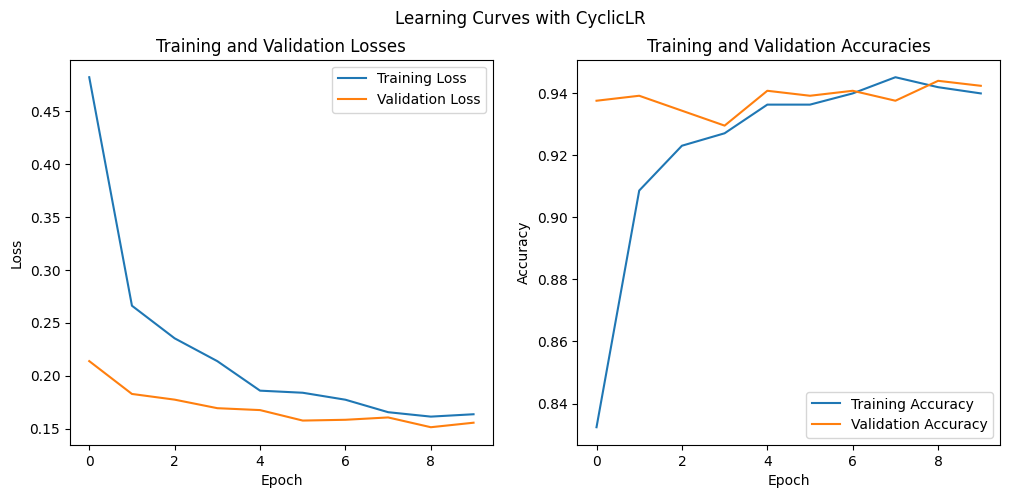

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "CyclicLR")

### Step LR

In [ ]:
# Instantiate the model
model = CustomMobileNetV3(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.483 | Train Acc: 84.88% | Train F1: 84.87%
	 Val. Loss: 0.226 |  Val. Acc: 94.23% | Val F1: 94.26%
Epoch: 02
	Train Loss: 0.256 | Train Acc: 91.38% | Train F1: 91.37%
	 Val. Loss: 0.187 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 03
	Train Loss: 0.222 | Train Acc: 92.70% | Train F1: 92.70%
	 Val. Loss: 0.174 |  Val. Acc: 93.59% | Val F1: 93.62%
Epoch: 04
	Train Loss: 0.217 | Train Acc: 92.46% | Train F1: 92.46%
	 Val. Loss: 0.165 |  Val. Acc: 93.91% | Val F1: 93.95%
Epoch: 05
	Train Loss: 0.196 | Train Acc: 92.98% | Train F1: 92.98%
	 Val. Loss: 0.163 |  Val. Acc: 94.07% | Val F1: 94.10%
Epoch: 06
	Train Loss: 0.181 | Train Acc: 93.46% | Train F1: 93.46%
	 Val. Loss: 0.161 |  Val. Acc: 94.23% | Val F1: 94.26%
Epoch: 07
	Train Loss: 0.184 | Train Acc: 93.79% | Train F1: 93.79%
	 Val. Loss: 0.159 |  Val. Acc: 93.91% | Val F1: 93.94%
Epoch: 08
	Train Loss: 0.183 | Train Acc: 93.54% | Train F1: 93.55%
	 Val. Loss: 0.158 |  Val. Acc: 94.23% | Val F1: 94.25%
Epoch: 0

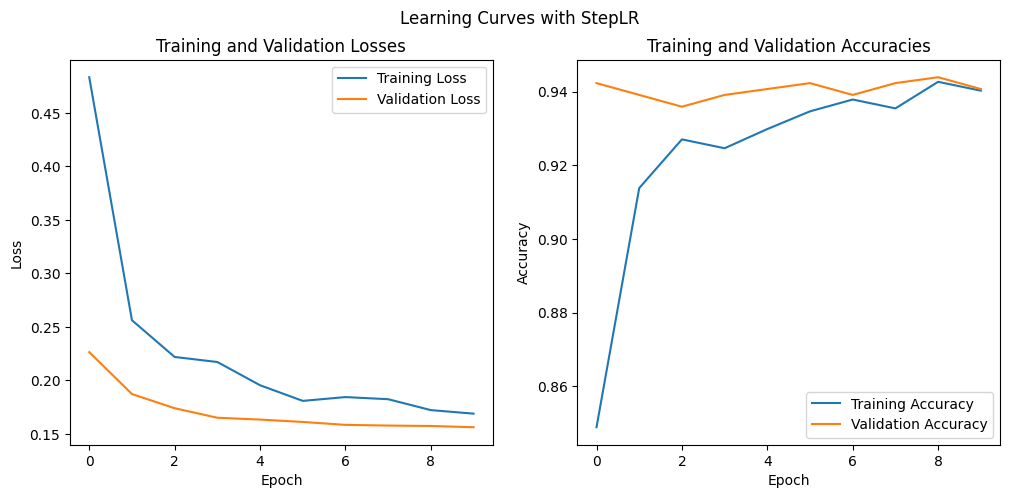

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "StepLR")

## Custom CNN

StepLR and LinearLR were the best choices for our Custom CNN based on the results although we see many ups and downs in all cases:

### Expotential LR

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

Epoch: 01
	Train Loss: 0.882 | Train Acc: 64.64% | Train F1: 64.43%
	 Val. Loss: 0.961 |  Val. Acc: 54.33% | Val F1: 46.05%
Epoch: 02
	Train Loss: 0.823 | Train Acc: 71.61% | Train F1: 71.63%
	 Val. Loss: 0.824 |  Val. Acc: 72.92% | Val F1: 72.06%
Epoch: 03
	Train Loss: 0.772 | Train Acc: 77.67% | Train F1: 77.79%
	 Val. Loss: 0.734 |  Val. Acc: 82.05% | Val F1: 81.86%
Epoch: 04
	Train Loss: 0.752 | Train Acc: 79.39% | Train F1: 79.54%
	 Val. Loss: 0.722 |  Val. Acc: 82.85% | Val F1: 82.63%
Epoch: 05
	Train Loss: 0.737 | Train Acc: 80.87% | Train F1: 80.97%
	 Val. Loss: 0.731 |  Val. Acc: 82.05% | Val F1: 82.37%
Epoch: 06
	Train Loss: 0.728 | Train Acc: 82.20% | Train F1: 82.23%
	 Val. Loss: 0.779 |  Val. Acc: 75.80% | Val F1: 75.12%
Epoch: 07
	Train Loss: 0.716 | Train Acc: 83.36% | Train F1: 83.40%
	 Val. Loss: 0.980 |  Val. Acc: 56.73% | Val F1: 51.45%
Epoch: 08
	Train Loss: 0.702 | Train Acc: 84.72% | Train F1: 84.78%
	 Val. Loss: 0.700 |  Val. Acc: 84.29% | Val F1: 84.34%
Epoch: 0

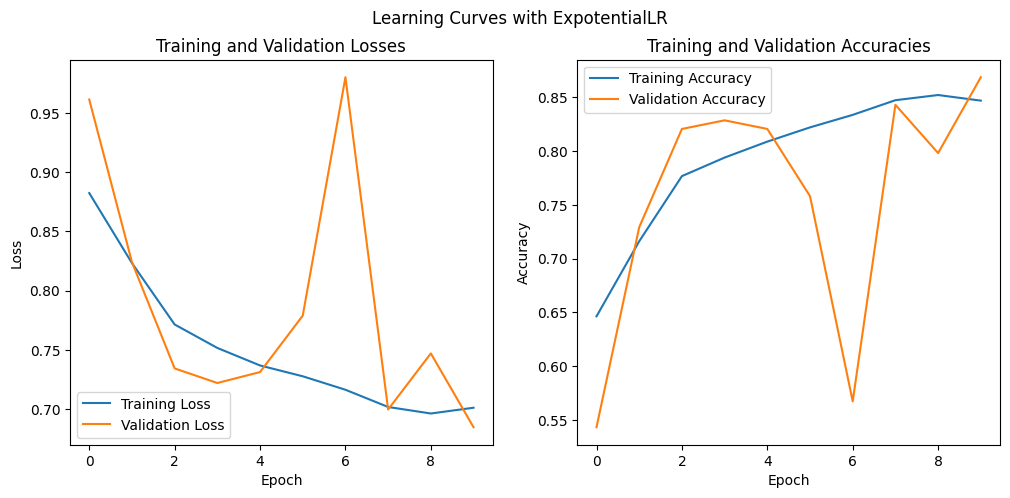

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "ExpotentialLR")

### Linear LR

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)

Epoch: 01
	Train Loss: 0.901 | Train Acc: 62.83% | Train F1: 62.72%
	 Val. Loss: 0.875 |  Val. Acc: 65.71% | Val F1: 64.54%
Epoch: 02
	Train Loss: 0.821 | Train Acc: 71.93% | Train F1: 72.15%
	 Val. Loss: 0.862 |  Val. Acc: 67.63% | Val F1: 67.02%
Epoch: 03
	Train Loss: 0.775 | Train Acc: 77.19% | Train F1: 77.33%
	 Val. Loss: 1.052 |  Val. Acc: 45.83% | Val F1: 35.21%
Epoch: 04
	Train Loss: 0.751 | Train Acc: 79.71% | Train F1: 79.76%
	 Val. Loss: 0.724 |  Val. Acc: 83.01% | Val F1: 83.35%
Epoch: 05
	Train Loss: 0.747 | Train Acc: 80.11% | Train F1: 80.21%
	 Val. Loss: 0.751 |  Val. Acc: 79.97% | Val F1: 78.83%
Epoch: 06
	Train Loss: 0.715 | Train Acc: 83.20% | Train F1: 83.26%
	 Val. Loss: 0.780 |  Val. Acc: 76.44% | Val F1: 75.38%
Epoch: 07
	Train Loss: 0.720 | Train Acc: 83.12% | Train F1: 83.16%
	 Val. Loss: 0.787 |  Val. Acc: 75.96% | Val F1: 73.92%
Epoch: 08
	Train Loss: 0.698 | Train Acc: 85.45% | Train F1: 85.45%
	 Val. Loss: 0.687 |  Val. Acc: 86.38% | Val F1: 86.36%
Epoch: 0

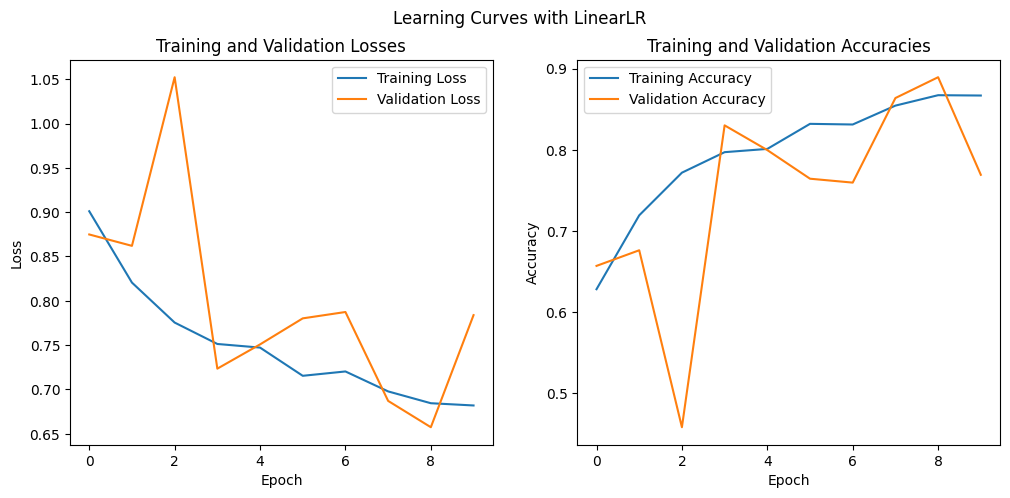

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "LinearLR")

### Cyclic LR

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2000, cycle_momentum=False)

Epoch: 01
	Train Loss: 0.881 | Train Acc: 66.24% | Train F1: 66.05%
	 Val. Loss: 0.812 |  Val. Acc: 75.00% | Val F1: 75.19%
Epoch: 02
	Train Loss: 0.806 | Train Acc: 73.94% | Train F1: 73.95%
	 Val. Loss: 0.781 |  Val. Acc: 77.88% | Val F1: 78.12%
Epoch: 03
	Train Loss: 0.777 | Train Acc: 77.23% | Train F1: 77.27%
	 Val. Loss: 0.822 |  Val. Acc: 73.88% | Val F1: 74.63%
Epoch: 04
	Train Loss: 0.772 | Train Acc: 77.31% | Train F1: 77.42%
	 Val. Loss: 0.794 |  Val. Acc: 75.64% | Val F1: 75.14%
Epoch: 05
	Train Loss: 0.761 | Train Acc: 77.95% | Train F1: 78.03%
	 Val. Loss: 0.800 |  Val. Acc: 74.84% | Val F1: 74.13%
Epoch: 06
	Train Loss: 0.739 | Train Acc: 80.79% | Train F1: 80.92%
	 Val. Loss: 0.818 |  Val. Acc: 72.12% | Val F1: 70.96%
Epoch: 07
	Train Loss: 0.744 | Train Acc: 80.23% | Train F1: 80.22%
	 Val. Loss: 0.981 |  Val. Acc: 55.61% | Val F1: 46.79%
Epoch: 08
	Train Loss: 0.728 | Train Acc: 82.12% | Train F1: 82.15%
	 Val. Loss: 0.913 |  Val. Acc: 63.30% | Val F1: 57.19%
Epoch: 0

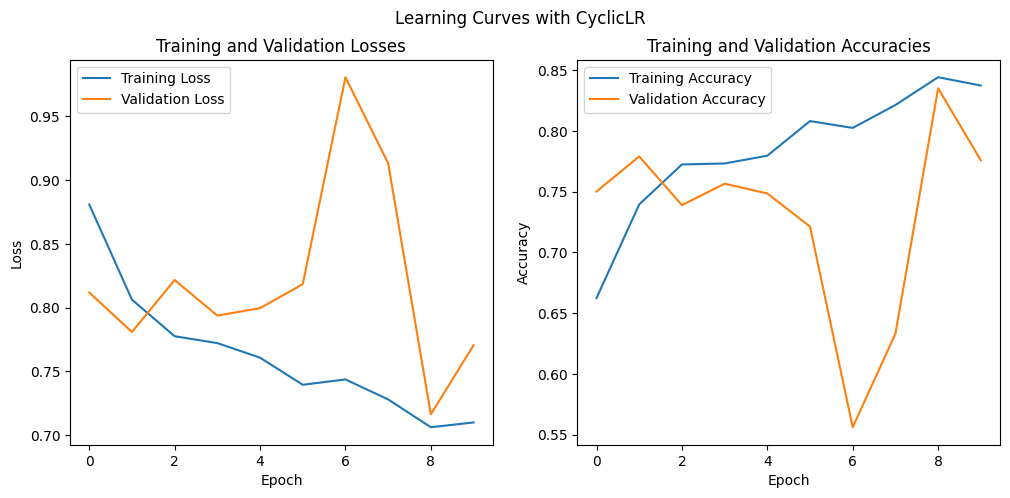

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "CyclicLR")

### Step LR

In [ ]:
# Instantiate the model
model = CNNModel(3)
model.to(device)
clear_output()

In [ ]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Epoch: 01
	Train Loss: 0.889 | Train Acc: 65.00% | Train F1: 65.02%
	 Val. Loss: 0.905 |  Val. Acc: 62.18% | Val F1: 60.09%
Epoch: 02
	Train Loss: 0.801 | Train Acc: 74.18% | Train F1: 74.30%
	 Val. Loss: 0.903 |  Val. Acc: 63.30% | Val F1: 64.08%
Epoch: 03
	Train Loss: 0.790 | Train Acc: 75.34% | Train F1: 75.42%
	 Val. Loss: 1.188 |  Val. Acc: 32.37% | Val F1: 17.06%
Epoch: 04
	Train Loss: 0.761 | Train Acc: 78.79% | Train F1: 78.87%
	 Val. Loss: 0.730 |  Val. Acc: 81.73% | Val F1: 81.63%
Epoch: 05
	Train Loss: 0.749 | Train Acc: 80.03% | Train F1: 80.14%
	 Val. Loss: 0.889 |  Val. Acc: 65.71% | Val F1: 61.38%
Epoch: 06
	Train Loss: 0.727 | Train Acc: 82.12% | Train F1: 82.17%
	 Val. Loss: 0.693 |  Val. Acc: 85.90% | Val F1: 85.98%
Epoch: 07
	Train Loss: 0.703 | Train Acc: 84.92% | Train F1: 84.95%
	 Val. Loss: 0.709 |  Val. Acc: 84.13% | Val F1: 84.19%
Epoch: 08
	Train Loss: 0.700 | Train Acc: 85.00% | Train F1: 85.04%
	 Val. Loss: 0.674 |  Val. Acc: 87.34% | Val F1: 87.41%
Epoch: 0

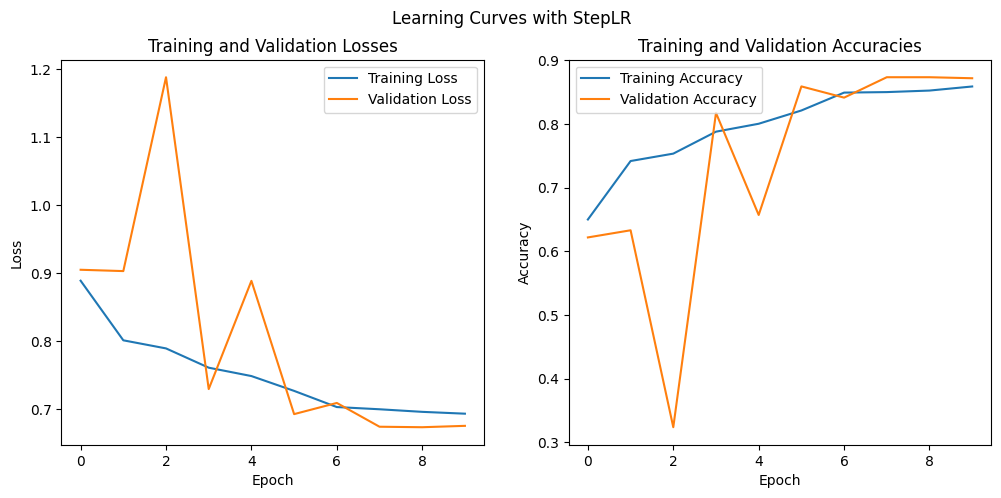

In [ ]:
# Train the model
num_epochs = 10

train_loss, val_loss, train_acc, val_acc = train_model_with_schedular(model,
                                                                      train_loader,
                                                                      val_loader,
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler)

plot_learning_curves(train_loss, val_loss, train_acc, val_acc, "StepLR")